# Libraries

In [1]:
import numpy as np
import torch
import torch.nn as nn
from torchvision import datasets
from torchvision import transforms
from torch.utils.data.sampler import SubsetRandomSampler
from torchsummary import summary
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
from torchvision.models import vgg11
import torchvision.transforms as transforms
from torchvision import datasets
from torch.utils.data.sampler import SubsetRandomSampler
import numpy as np

/root/miniconda3/envs/torch2/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")

In [ ]:
print(device)

cuda:1


# Dataset Loader

In [3]:
train_loader, valid_loader,train_loader_SI, test_loader = load_loaders('data_loaders.pkl')

100%|██████████| 170498071/170498071 [00:03<00:00, 47685257.70it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified
Files already downloaded and verified


# Functions

In [4]:
import torch
import torch.nn as nn
from torch.optim.lr_scheduler import StepLR
from tqdm import tqdm
import matplotlib.pyplot as plt

def train_and_validate(model, train_loader, valid_loader, test_loader, num_epochs=15, early_stopping_threshold=10, device='cuda', save_filename=None):
    # Define criterion, optimizer, and learning rate scheduler
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=0.01, weight_decay=5e-4, momentum=0.9)
    scheduler = StepLR(optimizer, step_size=5, gamma=0.1)

    # Initialize variables for tracking best accuracy and corresponding model weights
    best_val_acc = 0.0
    best_model_weights = None
    early_stopping_counter = 0

    # Lists to store metrics
    train_loss_list = []
    train_acc_list = []
    val_loss_list = []
    val_acc_list = []

    total_step = len(train_loader)

    for epoch in tqdm(range(num_epochs)):
        model.train()
        correct_train = 0
        total_train = 0
        running_loss = 0.0

        for i, (images, labels) in enumerate(train_loader):
            # Move tensors to the configured device
            images = images.to(device)
            labels = labels.to(device)

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)

            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Calculate training accuracy
            _, predicted_train = torch.max(outputs.data, 1)
            total_train += labels.size(0)
            correct_train += (predicted_train == labels).sum().item()

            running_loss += loss.item()

        # Calculate and store training accuracy and loss
        epoch_train_accuracy = 100 * correct_train / total_train
        epoch_train_loss = running_loss / len(train_loader)
        train_acc_list.append(epoch_train_accuracy)
        train_loss_list.append(epoch_train_loss)

        # Step the learning rate scheduler
        scheduler.step()

        # Validation
        with torch.no_grad():
            model.eval()
            correct = 0
            total = 0
            val_loss = 0

            for images, labels in valid_loader:
                images = images.to(device)
                labels = labels.to(device)
                outputs = model(images)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
                val_loss += criterion(outputs, labels).item()

            # Calculate validation accuracy
            current_val_acc = 100 * correct / total

            # Store validation loss and accuracy
            val_loss_list.append(val_loss / len(valid_loader))
            val_acc_list.append(current_val_acc)

            # Check if the current accuracy is the best so far
            if current_val_acc > best_val_acc:
                best_val_acc = current_val_acc
                # Save the model weights
                best_model_weights = model.state_dict()
                # Reset early stopping counter
                early_stopping_counter = 0
            else:
                # Increment early stopping counter
                early_stopping_counter += 1

            # Check for early stopping
            if early_stopping_counter >= early_stopping_threshold:
                print(f'Early stopping after {early_stopping_counter} epochs without improvement.')
                break

        # Print and save metrics
        print('Epoch [{}/{}], Step [{}/{}], Training Loss: {:.4f}, Training Accuracy: {:.2f}%, Validation Accuracy: {:.2f}%, Validation Loss: {:.4f}'
              .format(epoch + 1, num_epochs, i + 1, total_step, epoch_train_loss, epoch_train_accuracy, current_val_acc, val_loss_list[-1]))

    # Print test set accuracy on the best weights
    test_accuracy = test_model(model, test_loader, device)
    print(f'Test Set Accuracy on Best Weights: {test_accuracy:.2f}%')

    # Save the model with the best validation accuracy
    torch.save(best_model_weights, save_filename)

    # Plot training and validation metrics
    plot_metrics(train_loss_list, val_loss_list, train_acc_list, val_acc_list)

def test_model(model, test_loader, device='cuda'):
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    test_accuracy = 100 * correct / total
    return test_accuracy

def plot_metrics(train_loss_list, val_loss_list, train_acc_list, val_acc_list):
    # Plot training and validation loss
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.plot(train_loss_list, label='Training Loss')
    plt.plot(val_loss_list, label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    # Plot training and validation accuracy
    plt.subplot(1, 2, 2)
    plt.plot(train_acc_list, label='Training Accuracy')
    plt.plot(val_acc_list, label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.legend()

    plt.tight_layout()
    plt.show()

In [5]:
# Print the summary with information about frozen layers
def print_trainable_status(module, prefix=""):
    for name, child in module.named_children():
        for param in child.parameters():
            print(f"{prefix}{'.'.join([module._get_name(), name])}: requires_grad={param.requires_grad}")
        print_trainable_status(child, prefix + "  ")

In [4]:
!git clone https://github.com/Arhosseini77/data_complexity_measures

Cloning into 'data_complexity_measures'...
remote: Enumerating objects: 143, done.
remote: Counting objects: 100% (143/143), done.
remote: Compressing objects: 100% (130/130), done.
remote: Total 143 (delta 82), reused 33 (delta 9), pack-reused 0
Receiving objects: 100% (143/143), 144.63 KiB | 744.00 KiB/s, done.
Resolving deltas: 100% (82/82), done.


In [2]:
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
from tqdm import tqdm
from data_complexity_measures.models.ARH_SeparationIndex import ARH_SeparationIndex

# First Layer

In [6]:
import torch.nn as nn

class VGG_first_layer(nn.Module):
    def __init__(self, num_classes=10):
        super(VGG_first_layer, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.fc1 = nn.Sequential(
            nn.Linear(64 * 16 * 16, 512)
        )
        self.fc2 = nn.Sequential(
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        out = self.layer1(x)
        out = out.view(out.size(0), -1)
        out = self.fc1(out)
        out = self.fc2(out)
        return out

# Define device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Create model
model = VGG_first_layer()

# Move the model to the specified device
model.to(device)

VGG_first_layer(
  (layer1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Sequential(
    (0): Linear(in_features=16384, out_features=512, bias=True)
  )
  (fc2): Sequential(
    (0): Linear(in_features=512, out_features=10, bias=True)
  )
)

  7%|▋         | 1/15 [00:41<09:37, 41.22s/it]

Epoch [1/15], Step [352/352], Training Loss: 1.7164, Training Accuracy: 41.09%, Validation Accuracy: 49.16%, Validation Loss: 1.4276


 13%|█▎        | 2/15 [01:22<08:57, 41.38s/it]

Epoch [2/15], Step [352/352], Training Loss: 1.3788, Training Accuracy: 51.08%, Validation Accuracy: 52.16%, Validation Loss: 1.3444


 20%|██        | 3/15 [02:03<08:15, 41.27s/it]

Epoch [3/15], Step [352/352], Training Loss: 1.2877, Training Accuracy: 54.74%, Validation Accuracy: 54.82%, Validation Loss: 1.3080


 27%|██▋       | 4/15 [02:44<07:31, 41.01s/it]

Epoch [4/15], Step [352/352], Training Loss: 1.2262, Training Accuracy: 57.14%, Validation Accuracy: 57.54%, Validation Loss: 1.2127


 33%|███▎      | 5/15 [03:25<06:48, 40.89s/it]

Epoch [5/15], Step [352/352], Training Loss: 1.1764, Training Accuracy: 58.92%, Validation Accuracy: 57.60%, Validation Loss: 1.2166


 40%|████      | 6/15 [04:05<06:07, 40.85s/it]

Epoch [6/15], Step [352/352], Training Loss: 1.0633, Training Accuracy: 63.51%, Validation Accuracy: 62.38%, Validation Loss: 1.0860


 47%|████▋     | 7/15 [04:46<05:26, 40.81s/it]

Epoch [7/15], Step [352/352], Training Loss: 1.0422, Training Accuracy: 64.23%, Validation Accuracy: 62.32%, Validation Loss: 1.0770


 53%|█████▎    | 8/15 [05:27<04:45, 40.72s/it]

Epoch [8/15], Step [352/352], Training Loss: 1.0311, Training Accuracy: 64.56%, Validation Accuracy: 62.72%, Validation Loss: 1.0711


 60%|██████    | 9/15 [06:09<04:07, 41.26s/it]

Epoch [9/15], Step [352/352], Training Loss: 1.0254, Training Accuracy: 64.73%, Validation Accuracy: 63.88%, Validation Loss: 1.0542


 67%|██████▋   | 10/15 [06:50<03:26, 41.27s/it]

Epoch [10/15], Step [352/352], Training Loss: 1.0159, Training Accuracy: 65.34%, Validation Accuracy: 64.00%, Validation Loss: 1.0447


 73%|███████▎  | 11/15 [07:32<02:44, 41.22s/it]

Epoch [11/15], Step [352/352], Training Loss: 0.9995, Training Accuracy: 65.76%, Validation Accuracy: 64.00%, Validation Loss: 1.0584


 80%|████████  | 12/15 [08:12<02:03, 41.04s/it]

Epoch [12/15], Step [352/352], Training Loss: 0.9965, Training Accuracy: 65.80%, Validation Accuracy: 64.18%, Validation Loss: 1.0389


 87%|████████▋ | 13/15 [08:53<01:22, 41.05s/it]

Epoch [13/15], Step [352/352], Training Loss: 0.9968, Training Accuracy: 66.04%, Validation Accuracy: 64.26%, Validation Loss: 1.0540


 93%|█████████▎| 14/15 [09:34<00:40, 40.99s/it]

Epoch [14/15], Step [352/352], Training Loss: 0.9936, Training Accuracy: 65.87%, Validation Accuracy: 63.58%, Validation Loss: 1.0351


100%|██████████| 15/15 [10:15<00:00, 41.02s/it]

Epoch [15/15], Step [352/352], Training Loss: 0.9938, Training Accuracy: 65.96%, Validation Accuracy: 63.90%, Validation Loss: 1.0358


Test Set Accuracy on Best Weights: 67.32%


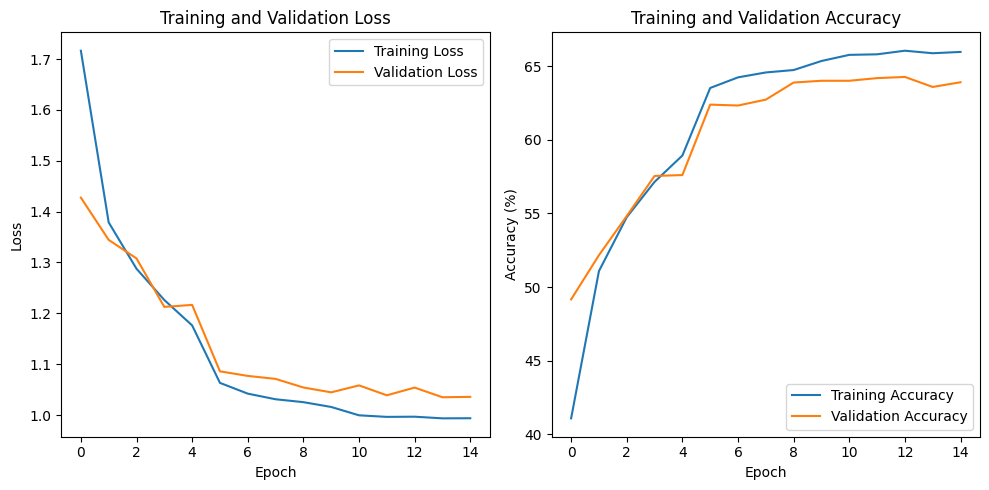

In [11]:
train_and_validate(model, train_loader, valid_loader, test_loader, num_epochs=15, early_stopping_threshold=10, device='cuda:0' ,  save_filename = 'first_layer_no_freeze.pth' )

# Center SI first layer - train

In [10]:
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
model = VGG_first_layer().to(device)
model.load_state_dict(torch.load('first_layer_no_freeze.pth'))
model.to('cuda:1' if torch.cuda.is_available() else 'cpu')
model.eval()
# Prepare storage for outputs and labels
features_per_layer = {}
labels_list = []

# Define layers to exclude
exclude_layers = {'' }

# Function to attach hooks
def get_layer_outputs(layer_name):
    def hook(module, input, output):
        features_per_layer[layer_name].append(output.detach())
    return hook

# Attach hooks to each layer except the excluded ones
for name, layer in model.named_children():
    if name not in exclude_layers:
        features_per_layer[name] = []
        layer.register_forward_hook(get_layer_outputs(name))
        
# Pass data through the model and collect layer outputs
with torch.no_grad():
    for inputs, targets in tqdm(train_loader_SI): 
        inputs = inputs.to('cuda:1' if torch.cuda.is_available() else 'cpu')

        # Trigger the hooks and collect layer outputs
        model(inputs)
        labels_list.append(targets.cpu())

        # Clear CUDA cache after processing each batch
        if torch.cuda.is_available():
            torch.cuda.empty_cache()

# Post-process the data: Flatten and concatenate
for layer_name, layer_features in features_per_layer.items():
    if layer_features:  # Check if layer_features is not empty
        try:
            features_per_layer[layer_name] = torch.cat([f.view(f.size(0), -1) for f in layer_features])
        except RuntimeError as e:
            print(f"Error in concatenating features of layer {layer_name}")
            for f in layer_features:
                print(f.shape)
            raise e
# Concatenate the labels
labels = torch.cat(labels_list)     

csi_layer_train = []

# Iterate through each layer's features in the dictionary
for layer_name, features in features_per_layer.items():
    instance_disturbance = ARH_SeparationIndex(features, labels, normalize=True)
    csi = instance_disturbance.center_si_batch(batch_size=2000)
    csi_layer_train.append((layer_name, csi))

100%|██████████| 36/36 [00:00<00:00, 115.87it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 3/3 [00:00<00:00, 384.30it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 3/3 [00:00<00:00, 1643.97it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 3/3 [00:00<00:00, 3091.62it/s]


[('layer1', 0.3897777795791626), ('fc1', 0.6415555477142334), ('fc2', 0.5815555453300476)]


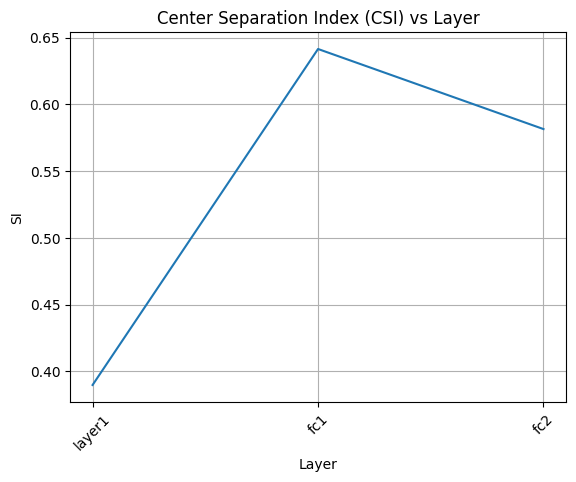

In [11]:
print(csi_layer_train)

# Plotting SI versus layer using a line plot
plt.plot([layer for layer, _ in csi_layer_train], [si for _, si in csi_layer_train])
plt.xlabel('Layer')
plt.ylabel('SI')
plt.title('Center Separation Index (CSI) vs Layer')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

# CSI first layer - test

100%|██████████| 79/79 [00:01<00:00, 53.46it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 5/5 [00:00<00:00, 781.32it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 5/5 [00:00<00:00, 3937.57it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 5/5 [00:00<00:00, 3989.26it/s]


[('layer1', 0.4017999768257141), ('fc1', 0.6507999897003174), ('fc2', 0.6031000018119812)]


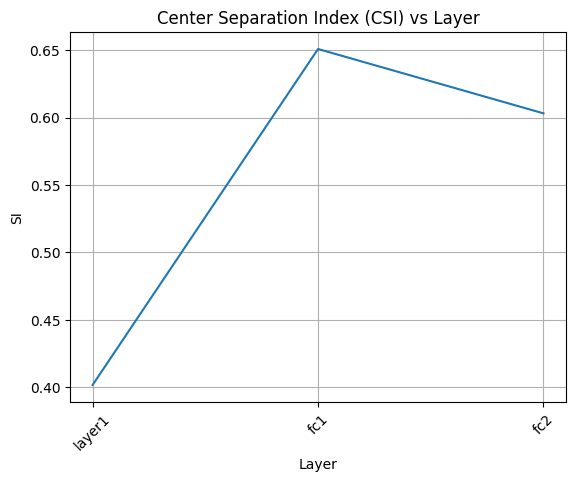

In [7]:
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
model = VGG_first_layer().to(device)
model.load_state_dict(torch.load('first_layer_no_freeze.pth'))
model.to('cuda:1' if torch.cuda.is_available() else 'cpu')
model.eval()
# Prepare storage for outputs and labels
features_per_layer = {}
labels_list = []

# Define layers to exclude
exclude_layers = {'' }

# Function to attach hooks
def get_layer_outputs(layer_name):
    def hook(module, input, output):
        features_per_layer[layer_name].append(output.detach())
    return hook

# Attach hooks to each layer except the excluded ones
for name, layer in model.named_children():
    if name not in exclude_layers:
        features_per_layer[name] = []
        layer.register_forward_hook(get_layer_outputs(name))
        
# Pass data through the model and collect layer outputs
with torch.no_grad():
    for inputs, targets in tqdm(test_loader): 
        inputs = inputs.to('cuda:1' if torch.cuda.is_available() else 'cpu')

        # Trigger the hooks and collect layer outputs
        model(inputs)
        labels_list.append(targets.cpu())

        # Clear CUDA cache after processing each batch
        if torch.cuda.is_available():
            torch.cuda.empty_cache()

# Post-process the data: Flatten and concatenate
for layer_name, layer_features in features_per_layer.items():
    if layer_features:  # Check if layer_features is not empty
        try:
            features_per_layer[layer_name] = torch.cat([f.view(f.size(0), -1) for f in layer_features])
        except RuntimeError as e:
            print(f"Error in concatenating features of layer {layer_name}")
            for f in layer_features:
                print(f.shape)
            raise e
# Concatenate the labels
labels = torch.cat(labels_list)     

csi_layer_train = []

# Iterate through each layer's features in the dictionary
for layer_name, features in features_per_layer.items():
    instance_disturbance = ARH_SeparationIndex(features, labels, normalize=True)
    csi = instance_disturbance.center_si_batch(batch_size=2000)
    csi_layer_train.append((layer_name, csi))
    
    
    
print(csi_layer_train)

# Plotting SI versus layer using a line plot
plt.plot([layer for layer, _ in csi_layer_train], [si for _, si in csi_layer_train])
plt.xlabel('Layer')
plt.ylabel('SI')
plt.title('Center Separation Index (CSI) vs Layer')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()   

# Second Layer

In [8]:
import torch.nn as nn

class VGG11_second_layer(nn.Module):
    def __init__(self, num_classes=10):
        super(VGG11_second_layer, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.layer2 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.fc1 = nn.Sequential(
            nn.Linear(8192, 512)
        )
        self.fc2 = nn.Sequential(
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.view(out.size(0), -1)
        out = self.fc1(out)
        out = self.fc2(out)
        return out


# Initialize your model
model = VGG11_second_layer().to(device)

model

VGG11_second_layer(
  (layer1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Sequential(
    (0): Linear(in_features=8192, out_features=512, bias=True)
  )
  (fc2): Sequential(
    (0): Linear(in_features=512, out_features=10, bias=True)
  )
)

  7%|▋         | 1/15 [00:41<09:39, 41.42s/it]

Epoch [1/15], Step [352/352], Training Loss: 1.4897, Training Accuracy: 46.62%, Validation Accuracy: 55.36%, Validation Loss: 1.2229


 13%|█▎        | 2/15 [01:22<08:58, 41.39s/it]

Epoch [2/15], Step [352/352], Training Loss: 1.1865, Training Accuracy: 57.68%, Validation Accuracy: 60.62%, Validation Loss: 1.0861


 20%|██        | 3/15 [02:03<08:14, 41.18s/it]

Epoch [3/15], Step [352/352], Training Loss: 1.0748, Training Accuracy: 62.12%, Validation Accuracy: 63.10%, Validation Loss: 1.0582


 27%|██▋       | 4/15 [02:44<07:30, 40.93s/it]

Epoch [4/15], Step [352/352], Training Loss: 1.0100, Training Accuracy: 64.73%, Validation Accuracy: 64.30%, Validation Loss: 1.0043


 33%|███▎      | 5/15 [03:25<06:49, 40.99s/it]

Epoch [5/15], Step [352/352], Training Loss: 0.9537, Training Accuracy: 66.65%, Validation Accuracy: 66.24%, Validation Loss: 0.9655


 40%|████      | 6/15 [04:06<06:08, 41.00s/it]

Epoch [6/15], Step [352/352], Training Loss: 0.8276, Training Accuracy: 71.50%, Validation Accuracy: 70.94%, Validation Loss: 0.8400


 47%|████▋     | 7/15 [04:48<05:30, 41.34s/it]

Epoch [7/15], Step [352/352], Training Loss: 0.8026, Training Accuracy: 72.37%, Validation Accuracy: 71.54%, Validation Loss: 0.8307


 53%|█████▎    | 8/15 [05:29<04:49, 41.30s/it]

Epoch [8/15], Step [352/352], Training Loss: 0.7902, Training Accuracy: 72.93%, Validation Accuracy: 71.10%, Validation Loss: 0.8234


 60%|██████    | 9/15 [06:10<04:07, 41.19s/it]

Epoch [9/15], Step [352/352], Training Loss: 0.7829, Training Accuracy: 73.16%, Validation Accuracy: 71.06%, Validation Loss: 0.8341


 67%|██████▋   | 10/15 [06:51<03:25, 41.15s/it]

Epoch [10/15], Step [352/352], Training Loss: 0.7761, Training Accuracy: 73.35%, Validation Accuracy: 71.94%, Validation Loss: 0.8107


 73%|███████▎  | 11/15 [07:32<02:44, 41.18s/it]

Epoch [11/15], Step [352/352], Training Loss: 0.7552, Training Accuracy: 74.20%, Validation Accuracy: 71.72%, Validation Loss: 0.8025


 80%|████████  | 12/15 [08:14<02:03, 41.19s/it]

Epoch [12/15], Step [352/352], Training Loss: 0.7535, Training Accuracy: 74.22%, Validation Accuracy: 72.60%, Validation Loss: 0.8074


 87%|████████▋ | 13/15 [08:55<01:22, 41.10s/it]

Epoch [13/15], Step [352/352], Training Loss: 0.7523, Training Accuracy: 74.19%, Validation Accuracy: 72.48%, Validation Loss: 0.7832


 93%|█████████▎| 14/15 [09:38<00:41, 41.70s/it]

Epoch [14/15], Step [352/352], Training Loss: 0.7504, Training Accuracy: 74.45%, Validation Accuracy: 72.16%, Validation Loss: 0.7998


100%|██████████| 15/15 [10:21<00:00, 41.45s/it]

Epoch [15/15], Step [352/352], Training Loss: 0.7465, Training Accuracy: 74.46%, Validation Accuracy: 72.60%, Validation Loss: 0.7943


Test Set Accuracy on Best Weights: 74.65%


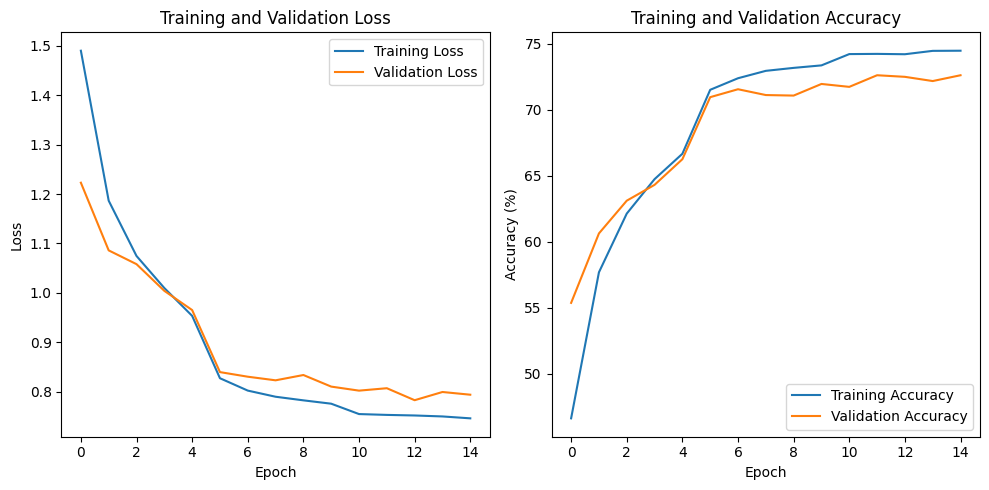

In [13]:
train_and_validate(model, train_loader, valid_loader, test_loader, num_epochs=15, early_stopping_threshold=10, device='cuda:0' ,  save_filename = 'second_layer_no_freeze.pth' )

# Center SI second layer - train

100%|██████████| 36/36 [00:00<00:00, 355.40it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 3/3 [00:00<00:00, 1878.89it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 3/3 [00:00<00:00, 2789.38it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 3/3 [00:00<00:00, 1724.87it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 3/3 [00:00<00:00, 3088.59it/s]

[('layer1', 0.4000000059604645), ('layer2', 0.5048888921737671), ('fc1', 0.7284444570541382), ('fc2', 0.6735555529594421)]


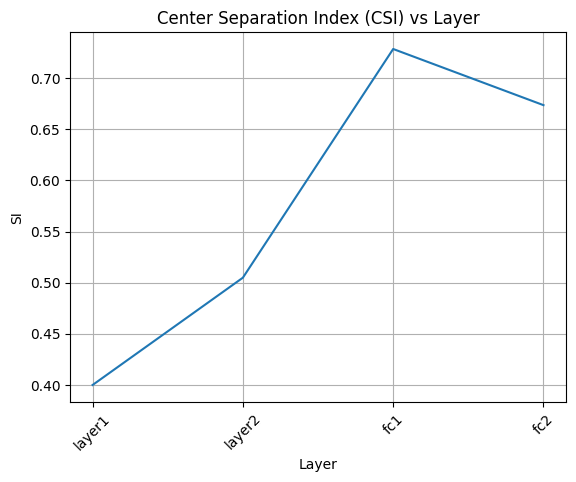

In [14]:
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
model = VGG11_second_layer().to(device)
model.load_state_dict(torch.load('second_layer_no_freeze.pth'))
model.to('cuda:1' if torch.cuda.is_available() else 'cpu')
model.eval()

# Prepare storage for outputs and labels
features_per_layer = {}
labels_list = []

# Define layers to exclude
exclude_layers = {'' }

# Function to attach hooks
def get_layer_outputs(layer_name):
    def hook(module, input, output):
        features_per_layer[layer_name].append(output.detach())
    return hook

# Attach hooks to each layer except the excluded ones
for name, layer in model.named_children():
    if name not in exclude_layers:
        features_per_layer[name] = []
        layer.register_forward_hook(get_layer_outputs(name))

# Pass data through the model and collect layer outputs
with torch.no_grad():
    for inputs, targets in tqdm(train_loader_SI): 
        inputs = inputs.to('cuda:1' if torch.cuda.is_available() else 'cpu')

        # Trigger the hooks and collect layer outputs
        model(inputs)
        labels_list.append(targets.cpu())

        # Clear CUDA cache after processing each batch
        if torch.cuda.is_available():
            torch.cuda.empty_cache()

# Post-process the data: Flatten and concatenate
for layer_name, layer_features in features_per_layer.items():
    if layer_features:  # Check if layer_features is not empty
        try:
            features_per_layer[layer_name] = torch.cat([f.view(f.size(0), -1) for f in layer_features])
        except RuntimeError as e:
            print(f"Error in concatenating features of layer {layer_name}")
            for f in layer_features:
                print(f.shape)
            raise e
# Concatenate the labels
labels = torch.cat(labels_list)

csi_layer_train = []

# Iterate through each layer's features in the dictionary
for layer_name, features in features_per_layer.items():
    instance_disturbance = ARH_SeparationIndex(features, labels, normalize=True)
    csi = instance_disturbance.center_si_batch(batch_size=2000)
    csi_layer_train.append((layer_name, csi))

print(csi_layer_train)


# Plotting SI versus layer using a line plot
plt.plot([layer for layer, _ in csi_layer_train], [si for _, si in csi_layer_train])
plt.xlabel('Layer')
plt.ylabel('SI')
plt.title('Center Separation Index (CSI) vs Layer')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()    

[('layer1', 0.4000000059604645), ('layer2', 0.5048888921737671), ('fc1', 0.7284444570541382), ('fc2', 0.6735555529594421)]


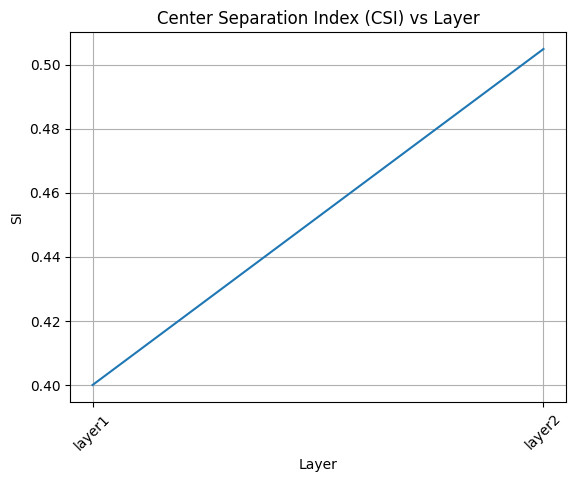

In [15]:
print(csi_layer_train)

# Plotting SI versus layer using a line plot
plt.plot([layer for layer, _ in csi_layer_train[0:-2]], [si for _, si in csi_layer_train[0:-2]])
plt.xlabel('Layer')
plt.ylabel('SI')
plt.title('Center Separation Index (CSI) vs Layer')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

# CSI second layer - test

100%|██████████| 79/79 [00:01<00:00, 59.59it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 5/5 [00:00<00:00, 3240.35it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 5/5 [00:00<00:00, 4052.47it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 5/5 [00:00<00:00, 3727.61it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 5/5 [00:00<00:00, 4453.50it/s]

[('layer1', 0.40379998087882996), ('layer2', 0.5023999810218811), ('fc1', 0.7272999882698059), ('fc2', 0.6839999556541443)]


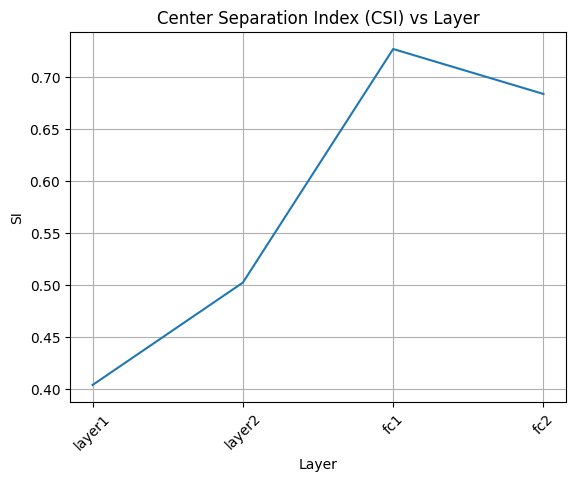

[('layer1', 0.40379998087882996), ('layer2', 0.5023999810218811), ('fc1', 0.7272999882698059), ('fc2', 0.6839999556541443)]


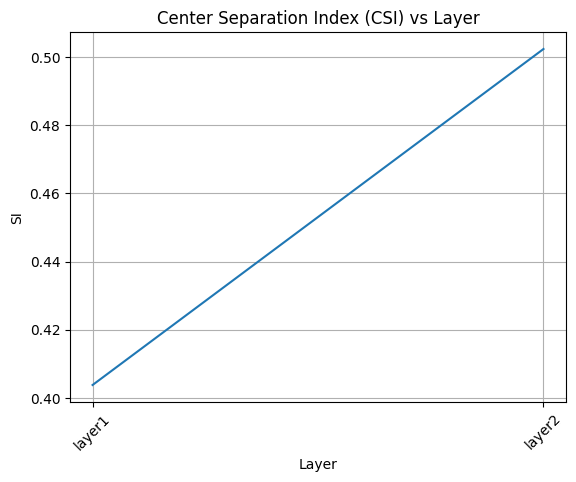

In [9]:
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
model = VGG11_second_layer().to(device)
model.load_state_dict(torch.load('second_layer_no_freeze.pth'))
model.to('cuda:1' if torch.cuda.is_available() else 'cpu')
model.eval()

# Prepare storage for outputs and labels
features_per_layer = {}
labels_list = []

# Define layers to exclude
exclude_layers = {'' }

# Function to attach hooks
def get_layer_outputs(layer_name):
    def hook(module, input, output):
        features_per_layer[layer_name].append(output.detach())
    return hook

# Attach hooks to each layer except the excluded ones
for name, layer in model.named_children():
    if name not in exclude_layers:
        features_per_layer[name] = []
        layer.register_forward_hook(get_layer_outputs(name))

# Pass data through the model and collect layer outputs
with torch.no_grad():
    for inputs, targets in tqdm(test_loader): 
        inputs = inputs.to('cuda:1' if torch.cuda.is_available() else 'cpu')

        # Trigger the hooks and collect layer outputs
        model(inputs)
        labels_list.append(targets.cpu())

        # Clear CUDA cache after processing each batch
        if torch.cuda.is_available():
            torch.cuda.empty_cache()

# Post-process the data: Flatten and concatenate
for layer_name, layer_features in features_per_layer.items():
    if layer_features:  # Check if layer_features is not empty
        try:
            features_per_layer[layer_name] = torch.cat([f.view(f.size(0), -1) for f in layer_features])
        except RuntimeError as e:
            print(f"Error in concatenating features of layer {layer_name}")
            for f in layer_features:
                print(f.shape)
            raise e
# Concatenate the labels
labels = torch.cat(labels_list)

csi_layer_train = []

# Iterate through each layer's features in the dictionary
for layer_name, features in features_per_layer.items():
    instance_disturbance = ARH_SeparationIndex(features, labels, normalize=True)
    csi = instance_disturbance.center_si_batch(batch_size=2000)
    csi_layer_train.append((layer_name, csi))

print(csi_layer_train)


# Plotting SI versus layer using a line plot
plt.plot([layer for layer, _ in csi_layer_train], [si for _, si in csi_layer_train])
plt.xlabel('Layer')
plt.ylabel('SI')
plt.title('Center Separation Index (CSI) vs Layer')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()   


print(csi_layer_train)

# Plotting SI versus layer using a line plot
plt.plot([layer for layer, _ in csi_layer_train[0:-2]], [si for _, si in csi_layer_train[0:-2]])
plt.xlabel('Layer')
plt.ylabel('SI')
plt.title('Center Separation Index (CSI) vs Layer')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

# Third Layer

In [10]:
import torch.nn as nn

class VGG11_third_layer(nn.Module):
    def __init__(self, num_classes=10):
        super(VGG11_third_layer, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.layer2 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.layer3 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU()
        )
        self.fc1 = nn.Sequential(
            nn.Linear(256 * 8 * 8, 512)
        )
        self.fc2 = nn.Sequential(
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = out.view(out.size(0), -1)
        out = self.fc1(out)
        out = self.fc2(out)
        return out

In [11]:
model = VGG11_third_layer().to(device)
model

VGG11_third_layer(
  (layer1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (fc1): Sequential(
    (0): Linear(in_features=16384, out_features=512, bias=True)
  )
  (fc2): Sequential(
    (0): Linear(in_features=512, out_features=10, bias=True)
  )
)

  7%|▋         | 1/15 [00:42<09:54, 42.48s/it]

Epoch [1/15], Step [352/352], Training Loss: 1.3508, Training Accuracy: 51.40%, Validation Accuracy: 60.54%, Validation Loss: 1.1093


 13%|█▎        | 2/15 [01:25<09:12, 42.52s/it]

Epoch [2/15], Step [352/352], Training Loss: 1.0283, Training Accuracy: 63.87%, Validation Accuracy: 63.94%, Validation Loss: 1.0218


 20%|██        | 3/15 [02:06<08:27, 42.26s/it]

Epoch [3/15], Step [352/352], Training Loss: 0.9143, Training Accuracy: 67.71%, Validation Accuracy: 67.74%, Validation Loss: 0.9329


 27%|██▋       | 4/15 [02:49<07:46, 42.40s/it]

Epoch [4/15], Step [352/352], Training Loss: 0.8306, Training Accuracy: 70.84%, Validation Accuracy: 68.22%, Validation Loss: 0.9120


 33%|███▎      | 5/15 [03:32<07:04, 42.41s/it]

Epoch [5/15], Step [352/352], Training Loss: 0.7753, Training Accuracy: 72.91%, Validation Accuracy: 71.04%, Validation Loss: 0.8589


 40%|████      | 6/15 [04:15<06:24, 42.72s/it]

Epoch [6/15], Step [352/352], Training Loss: 0.6134, Training Accuracy: 78.79%, Validation Accuracy: 77.00%, Validation Loss: 0.6596


 47%|████▋     | 7/15 [04:57<05:39, 42.46s/it]

Epoch [7/15], Step [352/352], Training Loss: 0.5773, Training Accuracy: 80.27%, Validation Accuracy: 77.50%, Validation Loss: 0.6493


 53%|█████▎    | 8/15 [05:39<04:55, 42.27s/it]

Epoch [8/15], Step [352/352], Training Loss: 0.5647, Training Accuracy: 80.48%, Validation Accuracy: 77.14%, Validation Loss: 0.6591


 60%|██████    | 9/15 [06:21<04:14, 42.33s/it]

Epoch [9/15], Step [352/352], Training Loss: 0.5493, Training Accuracy: 81.02%, Validation Accuracy: 77.78%, Validation Loss: 0.6266


 67%|██████▋   | 10/15 [07:04<03:31, 42.36s/it]

Epoch [10/15], Step [352/352], Training Loss: 0.5354, Training Accuracy: 81.68%, Validation Accuracy: 78.28%, Validation Loss: 0.6296


 73%|███████▎  | 11/15 [07:46<02:49, 42.37s/it]

Epoch [11/15], Step [352/352], Training Loss: 0.5166, Training Accuracy: 82.18%, Validation Accuracy: 78.98%, Validation Loss: 0.6115


 80%|████████  | 12/15 [08:28<02:06, 42.21s/it]

Epoch [12/15], Step [352/352], Training Loss: 0.5138, Training Accuracy: 82.20%, Validation Accuracy: 79.22%, Validation Loss: 0.6094


 87%|████████▋ | 13/15 [09:09<01:24, 42.05s/it]

Epoch [13/15], Step [352/352], Training Loss: 0.5109, Training Accuracy: 82.40%, Validation Accuracy: 79.12%, Validation Loss: 0.6176


 93%|█████████▎| 14/15 [09:51<00:42, 42.05s/it]

Epoch [14/15], Step [352/352], Training Loss: 0.5074, Training Accuracy: 82.55%, Validation Accuracy: 79.14%, Validation Loss: 0.6086


100%|██████████| 15/15 [10:34<00:00, 42.30s/it]

Epoch [15/15], Step [352/352], Training Loss: 0.5070, Training Accuracy: 82.45%, Validation Accuracy: 78.84%, Validation Loss: 0.6197


Test Set Accuracy on Best Weights: 80.60%


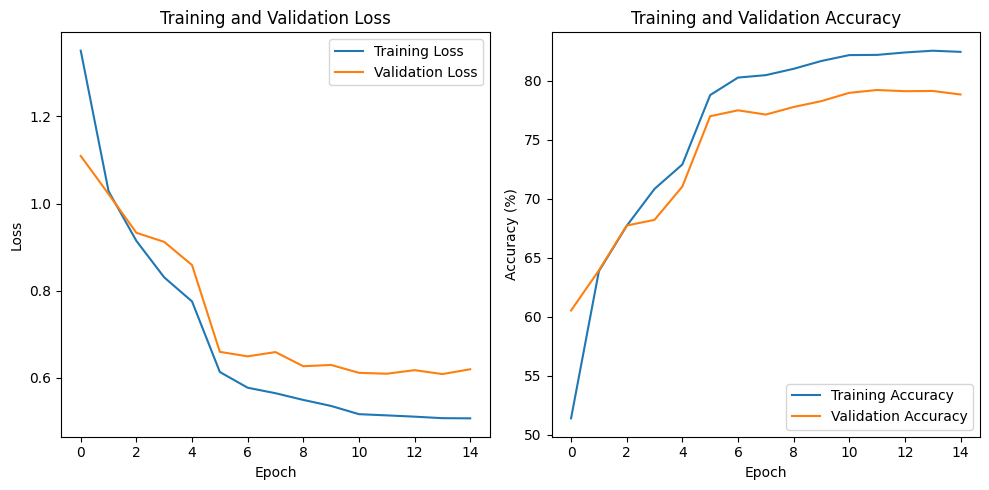

In [16]:
train_and_validate(model, train_loader, valid_loader, test_loader, num_epochs=15, early_stopping_threshold=10, device='cuda:0' ,  save_filename = 'third_layer_no_freeze.pth' )

# Center SI third layer - train

100%|██████████| 36/36 [00:00<00:00, 231.14it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 3/3 [00:00<00:00, 2071.60it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 3/3 [00:00<00:00, 2866.92it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 3/3 [00:00<00:00, 2259.86it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 3/3 [00:00<00:00, 1685.36it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 3/3 [00:00<00:00, 3179.91it/s]

[('layer1', 0.41377776861190796), ('layer2', 0.5133333206176758), ('layer3', 0.6202222108840942), ('fc1', 0.8111110925674438), ('fc2', 0.7711111307144165)]


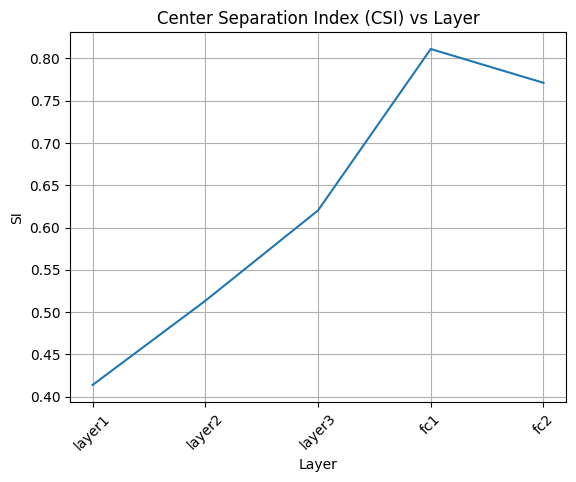

In [18]:
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
model = VGG11_third_layer().to(device)
model.load_state_dict(torch.load('third_layer_no_freeze.pth'))
model.to('cuda:1' if torch.cuda.is_available() else 'cpu')
model.eval()

# Prepare storage for outputs and labels
features_per_layer = {}
labels_list = []

# Define layers to exclude
exclude_layers = {'' }

# Function to attach hooks
def get_layer_outputs(layer_name):
    def hook(module, input, output):
        features_per_layer[layer_name].append(output.detach())
    return hook

# Attach hooks to each layer except the excluded ones
for name, layer in model.named_children():
    if name not in exclude_layers:
        features_per_layer[name] = []
        layer.register_forward_hook(get_layer_outputs(name))

# Pass data through the model and collect layer outputs
with torch.no_grad():
    for inputs, targets in tqdm(train_loader_SI): 
        inputs = inputs.to('cuda:1' if torch.cuda.is_available() else 'cpu')

        # Trigger the hooks and collect layer outputs
        model(inputs)
        labels_list.append(targets.cpu())

        # Clear CUDA cache after processing each batch
        if torch.cuda.is_available():
            torch.cuda.empty_cache()

# Post-process the data: Flatten and concatenate
for layer_name, layer_features in features_per_layer.items():
    if layer_features:  # Check if layer_features is not empty
        try:
            features_per_layer[layer_name] = torch.cat([f.view(f.size(0), -1) for f in layer_features])
        except RuntimeError as e:
            print(f"Error in concatenating features of layer {layer_name}")
            for f in layer_features:
                print(f.shape)
            raise e
# Concatenate the labels
labels = torch.cat(labels_list)

csi_layer_train = []

# Iterate through each layer's features in the dictionary
for layer_name, features in features_per_layer.items():
    instance_disturbance = ARH_SeparationIndex(features, labels, normalize=True)
    csi = instance_disturbance.center_si_batch(batch_size=2000)
    csi_layer_train.append((layer_name, csi))

print(csi_layer_train)


# Plotting SI versus layer using a line plot
plt.plot([layer for layer, _ in csi_layer_train], [si for _, si in csi_layer_train])
plt.xlabel('Layer')
plt.ylabel('SI')
plt.title('Center Separation Index (CSI) vs Layer')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()    

[('layer1', 0.41377776861190796), ('layer2', 0.5133333206176758), ('layer3', 0.6202222108840942), ('fc1', 0.8111110925674438), ('fc2', 0.7711111307144165)]


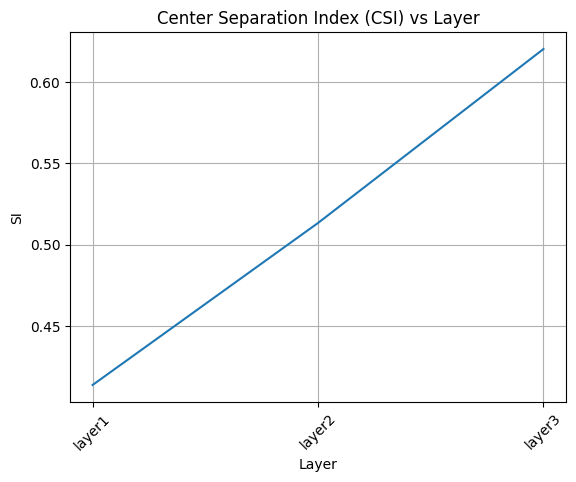

In [19]:
print(csi_layer_train)

# Plotting SI versus layer using a line plot
plt.plot([layer for layer, _ in csi_layer_train[0:-2]], [si for _, si in csi_layer_train[0:-2]])
plt.xlabel('Layer')
plt.ylabel('SI')
plt.title('Center Separation Index (CSI) vs Layer')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

# Center SI third layer - test

100%|██████████| 79/79 [00:01<00:00, 62.03it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 5/5 [00:00<00:00, 3002.37it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 5/5 [00:00<00:00, 4170.95it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 5/5 [00:00<00:00, 3209.60it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 5/5 [00:00<00:00, 4177.59it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 5/5 [00:00<00:00, 4456.34it/s]

[('layer1', 0.41920000314712524), ('layer2', 0.5246999859809875), ('layer3', 0.6197999715805054), ('fc1', 0.7901999950408936), ('fc2', 0.7508999705314636)]


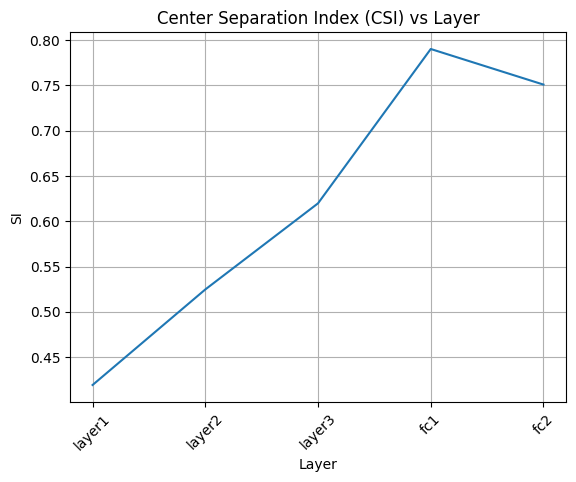

[('layer1', 0.41920000314712524), ('layer2', 0.5246999859809875), ('layer3', 0.6197999715805054), ('fc1', 0.7901999950408936), ('fc2', 0.7508999705314636)]


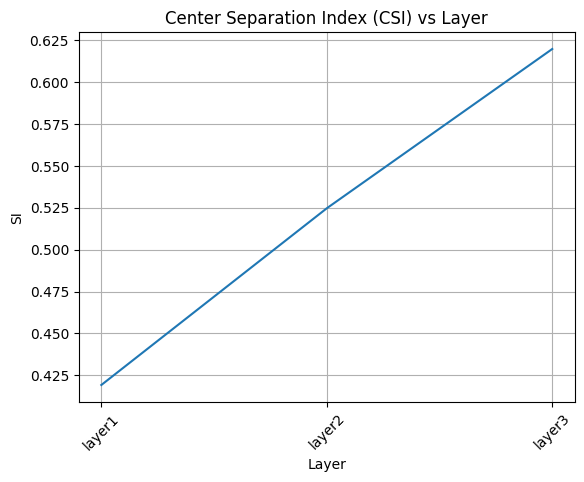

In [13]:
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
model = VGG11_third_layer().to(device)
model.load_state_dict(torch.load('third_layer_no_freeze.pth'))
model.to('cuda:1' if torch.cuda.is_available() else 'cpu')
model.eval()

# Prepare storage for outputs and labels
features_per_layer = {}
labels_list = []

# Define layers to exclude
exclude_layers = {'' }

# Function to attach hooks
def get_layer_outputs(layer_name):
    def hook(module, input, output):
        features_per_layer[layer_name].append(output.detach())
    return hook

# Attach hooks to each layer except the excluded ones
for name, layer in model.named_children():
    if name not in exclude_layers:
        features_per_layer[name] = []
        layer.register_forward_hook(get_layer_outputs(name))

# Pass data through the model and collect layer outputs
with torch.no_grad():
    for inputs, targets in tqdm(test_loader): 
        inputs = inputs.to('cuda:1' if torch.cuda.is_available() else 'cpu')

        # Trigger the hooks and collect layer outputs
        model(inputs)
        labels_list.append(targets.cpu())

        # Clear CUDA cache after processing each batch
        if torch.cuda.is_available():
            torch.cuda.empty_cache()

# Post-process the data: Flatten and concatenate
for layer_name, layer_features in features_per_layer.items():
    if layer_features:  # Check if layer_features is not empty
        try:
            features_per_layer[layer_name] = torch.cat([f.view(f.size(0), -1) for f in layer_features])
        except RuntimeError as e:
            print(f"Error in concatenating features of layer {layer_name}")
            for f in layer_features:
                print(f.shape)
            raise e
# Concatenate the labels
labels = torch.cat(labels_list)

csi_layer_train = []

# Iterate through each layer's features in the dictionary
for layer_name, features in features_per_layer.items():
    instance_disturbance = ARH_SeparationIndex(features, labels, normalize=True)
    csi = instance_disturbance.center_si_batch(batch_size=2000)
    csi_layer_train.append((layer_name, csi))

print(csi_layer_train)


# Plotting SI versus layer using a line plot
plt.plot([layer for layer, _ in csi_layer_train], [si for _, si in csi_layer_train])
plt.xlabel('Layer')
plt.ylabel('SI')
plt.title('Center Separation Index (CSI) vs Layer')
plt.xticks(rotation=45)
plt.grid(True)
plt.show() 

print(csi_layer_train)

# Plotting SI versus layer using a line plot
plt.plot([layer for layer, _ in csi_layer_train[0:-2]], [si for _, si in csi_layer_train[0:-2]])
plt.xlabel('Layer')
plt.ylabel('SI')
plt.title('Center Separation Index (CSI) vs Layer')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

# Fourth Layer

In [14]:
import torch.nn as nn

class VGG11_Fourth_Layer(nn.Module):
    def __init__(self, num_classes=10):
        super(VGG11_Fourth_Layer, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.layer2 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.layer3 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU()
        )
        self.layer4 = nn.Sequential(
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.fc1 = nn.Sequential(
            nn.Linear(256 * 4 * 4, 512)
        )
        self.fc2 = nn.Sequential(
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = out.view(out.size(0), -1)
        out = self.fc1(out)
        out = self.fc2(out)
        return out

In [15]:
import torch
import torch.nn as nn

# Initialize your model
model = VGG11_Fourth_Layer().to(device)

model

VGG11_Fourth_Layer(
  (layer1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (layer4): Sequential(
    (0): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats

  7%|▋         | 1/15 [00:42<09:55, 42.57s/it]

Epoch [1/15], Step [352/352], Training Loss: 1.3524, Training Accuracy: 51.12%, Validation Accuracy: 57.56%, Validation Loss: 1.1693


 13%|█▎        | 2/15 [01:24<09:11, 42.40s/it]

Epoch [2/15], Step [352/352], Training Loss: 0.9944, Training Accuracy: 64.84%, Validation Accuracy: 65.12%, Validation Loss: 0.9872


 20%|██        | 3/15 [02:07<08:31, 42.64s/it]

Epoch [3/15], Step [352/352], Training Loss: 0.8536, Training Accuracy: 69.94%, Validation Accuracy: 67.74%, Validation Loss: 0.9046


 27%|██▋       | 4/15 [02:50<07:47, 42.54s/it]

Epoch [4/15], Step [352/352], Training Loss: 0.7868, Training Accuracy: 72.35%, Validation Accuracy: 72.62%, Validation Loss: 0.8066


 33%|███▎      | 5/15 [03:32<07:05, 42.51s/it]

Epoch [5/15], Step [352/352], Training Loss: 0.7174, Training Accuracy: 74.96%, Validation Accuracy: 71.22%, Validation Loss: 0.8147


 40%|████      | 6/15 [04:16<06:27, 43.04s/it]

Epoch [6/15], Step [352/352], Training Loss: 0.5522, Training Accuracy: 80.96%, Validation Accuracy: 79.48%, Validation Loss: 0.5818


 47%|████▋     | 7/15 [05:00<05:45, 43.24s/it]

Epoch [7/15], Step [352/352], Training Loss: 0.5121, Training Accuracy: 82.38%, Validation Accuracy: 79.30%, Validation Loss: 0.5885


 53%|█████▎    | 8/15 [05:42<05:00, 42.99s/it]

Epoch [8/15], Step [352/352], Training Loss: 0.4923, Training Accuracy: 83.06%, Validation Accuracy: 80.18%, Validation Loss: 0.5869


 60%|██████    | 9/15 [06:25<04:17, 42.91s/it]

Epoch [9/15], Step [352/352], Training Loss: 0.4777, Training Accuracy: 83.47%, Validation Accuracy: 81.04%, Validation Loss: 0.5452


 67%|██████▋   | 10/15 [07:08<03:33, 42.78s/it]

Epoch [10/15], Step [352/352], Training Loss: 0.4674, Training Accuracy: 83.90%, Validation Accuracy: 81.52%, Validation Loss: 0.5483


 73%|███████▎  | 11/15 [07:51<02:52, 43.13s/it]

Epoch [11/15], Step [352/352], Training Loss: 0.4408, Training Accuracy: 84.76%, Validation Accuracy: 81.32%, Validation Loss: 0.5460


 80%|████████  | 12/15 [08:34<02:08, 42.96s/it]

Epoch [12/15], Step [352/352], Training Loss: 0.4371, Training Accuracy: 84.85%, Validation Accuracy: 81.60%, Validation Loss: 0.5228


 87%|████████▋ | 13/15 [09:17<01:25, 42.83s/it]

Epoch [13/15], Step [352/352], Training Loss: 0.4348, Training Accuracy: 84.93%, Validation Accuracy: 81.70%, Validation Loss: 0.5393


 93%|█████████▎| 14/15 [09:59<00:42, 42.74s/it]

Epoch [14/15], Step [352/352], Training Loss: 0.4316, Training Accuracy: 85.21%, Validation Accuracy: 81.70%, Validation Loss: 0.5396


100%|██████████| 15/15 [10:42<00:00, 42.84s/it]

Epoch [15/15], Step [352/352], Training Loss: 0.4288, Training Accuracy: 85.23%, Validation Accuracy: 81.42%, Validation Loss: 0.5309


Test Set Accuracy on Best Weights: 82.82%


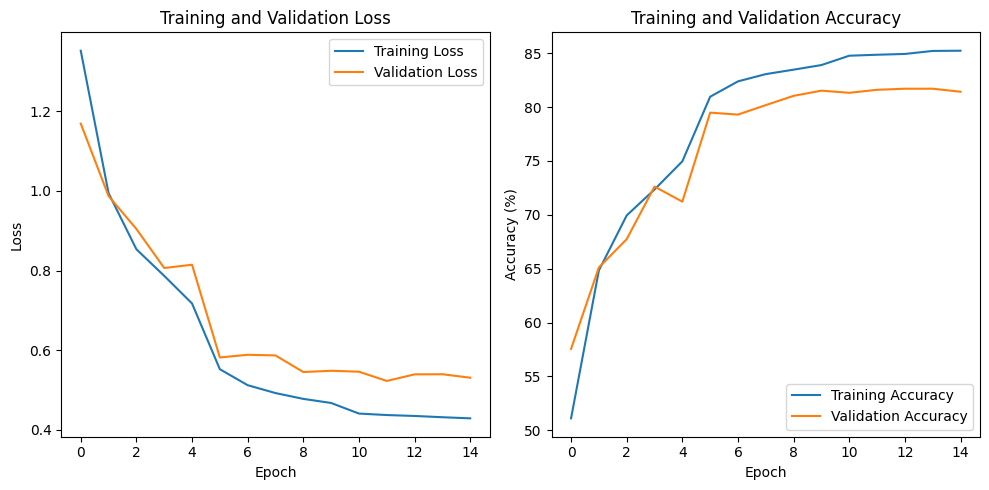

In [19]:
train_and_validate(model, train_loader, valid_loader, test_loader, num_epochs=15, early_stopping_threshold=10, device='cuda:0' ,  save_filename = 'fourth_layer_no_freeze.pth' )

# Fourth Layer CSI - train

100%|██████████| 36/36 [00:00<00:00, 239.98it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 3/3 [00:00<00:00, 2893.95it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 3/3 [00:00<00:00, 2870.84it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 3/3 [00:00<00:00, 3091.62it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 3/3 [00:00<00:00, 3000.93it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 3/3 [00:00<00:00, 1895.87it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 3/3 [00:00<00:00, 3297.41it/s]


[('layer1', 0.402444452047348), ('layer2', 0.5077778100967407), ('layer3', 0.5893333554267883), ('layer4', 0.679111123085022), ('fc1', 0.832444429397583), ('fc2', 0.7951111197471619)]


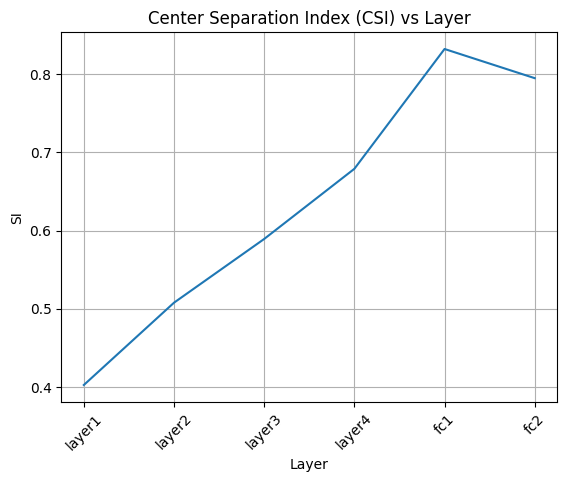

In [22]:
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
model = VGG11_Fourth_Layer().to(device)
model.load_state_dict(torch.load('fourth_layer_no_freeze.pth'))
model.to('cuda:1' if torch.cuda.is_available() else 'cpu')
model.eval()

# Prepare storage for outputs and labels
features_per_layer = {}
labels_list = []

# Define layers to exclude
exclude_layers = {'' }

# Function to attach hooks
def get_layer_outputs(layer_name):
    def hook(module, input, output):
        features_per_layer[layer_name].append(output.detach())
    return hook

# Attach hooks to each layer except the excluded ones
for name, layer in model.named_children():
    if name not in exclude_layers:
        features_per_layer[name] = []
        layer.register_forward_hook(get_layer_outputs(name))

# Pass data through the model and collect layer outputs
with torch.no_grad():
    for inputs, targets in tqdm(train_loader_SI): 
        inputs = inputs.to('cuda:1' if torch.cuda.is_available() else 'cpu')

        # Trigger the hooks and collect layer outputs
        model(inputs)
        labels_list.append(targets.cpu())

        # Clear CUDA cache after processing each batch
        if torch.cuda.is_available():
            torch.cuda.empty_cache()

# Post-process the data: Flatten and concatenate
for layer_name, layer_features in features_per_layer.items():
    if layer_features:  # Check if layer_features is not empty
        try:
            features_per_layer[layer_name] = torch.cat([f.view(f.size(0), -1) for f in layer_features])
        except RuntimeError as e:
            print(f"Error in concatenating features of layer {layer_name}")
            for f in layer_features:
                print(f.shape)
            raise e
# Concatenate the labels
labels = torch.cat(labels_list)

csi_layer_train = []

# Iterate through each layer's features in the dictionary
for layer_name, features in features_per_layer.items():
    instance_disturbance = ARH_SeparationIndex(features, labels, normalize=True)
    csi = instance_disturbance.center_si_batch(batch_size=2000)
    csi_layer_train.append((layer_name, csi))

print(csi_layer_train)


# Plotting SI versus layer using a line plot
plt.plot([layer for layer, _ in csi_layer_train], [si for _, si in csi_layer_train])
plt.xlabel('Layer')
plt.ylabel('SI')
plt.title('Center Separation Index (CSI) vs Layer')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()    

[('layer1', 0.402444452047348), ('layer2', 0.5077778100967407), ('layer3', 0.5893333554267883), ('layer4', 0.679111123085022), ('fc1', 0.832444429397583), ('fc2', 0.7951111197471619)]


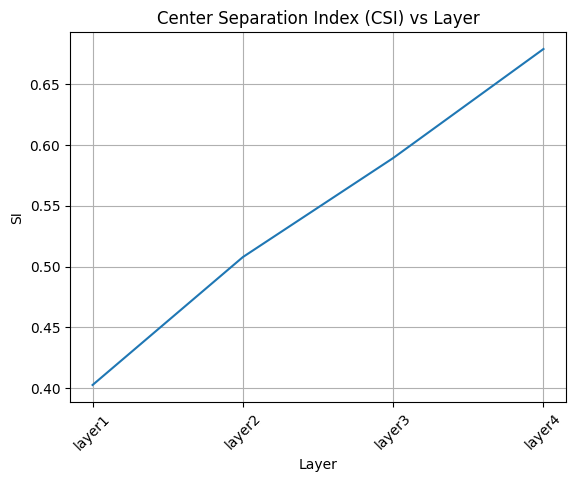

In [23]:
print(csi_layer_train)

# Plotting SI versus layer using a line plot
plt.plot([layer for layer, _ in csi_layer_train[0:-2]], [si for _, si in csi_layer_train[0:-2]])
plt.xlabel('Layer')
plt.ylabel('SI')
plt.title('Center Separation Index (CSI) vs Layer')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

# Fourth Layer CSI -test

100%|██████████| 79/79 [00:01<00:00, 60.47it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 5/5 [00:00<00:00, 2971.73it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 5/5 [00:00<00:00, 4034.54it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 5/5 [00:00<00:00, 3167.90it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 5/5 [00:00<00:00, 3986.22it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 5/5 [00:00<00:00, 4313.35it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 5/5 [00:00<00:00, 4163.49it/s]

[('layer1', 0.41110000014305115), ('layer2', 0.51419997215271), ('layer3', 0.5941999554634094), ('layer4', 0.668999969959259), ('fc1', 0.8101999759674072), ('fc2', 0.776699960231781)]


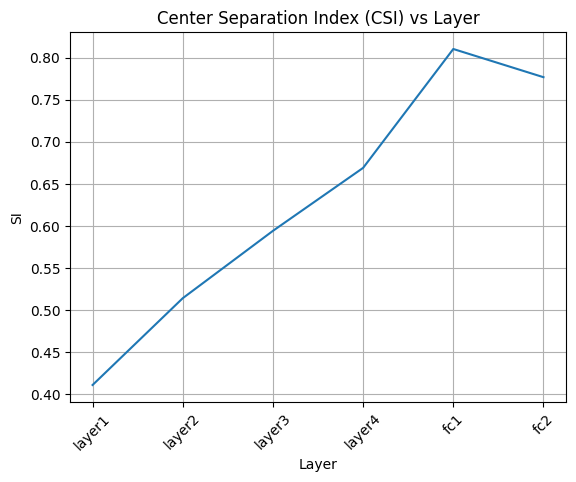

[('layer1', 0.41110000014305115), ('layer2', 0.51419997215271), ('layer3', 0.5941999554634094), ('layer4', 0.668999969959259), ('fc1', 0.8101999759674072), ('fc2', 0.776699960231781)]


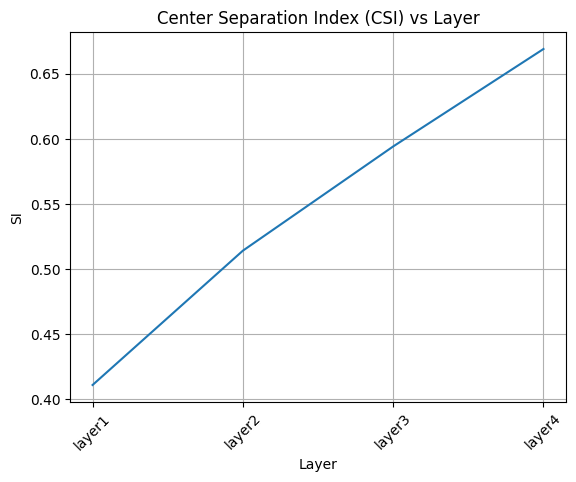

In [16]:
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
model = VGG11_Fourth_Layer().to(device)
model.load_state_dict(torch.load('fourth_layer_no_freeze.pth'))
model.to('cuda:1' if torch.cuda.is_available() else 'cpu')
model.eval()

# Prepare storage for outputs and labels
features_per_layer = {}
labels_list = []

# Define layers to exclude
exclude_layers = {'' }

# Function to attach hooks
def get_layer_outputs(layer_name):
    def hook(module, input, output):
        features_per_layer[layer_name].append(output.detach())
    return hook

# Attach hooks to each layer except the excluded ones
for name, layer in model.named_children():
    if name not in exclude_layers:
        features_per_layer[name] = []
        layer.register_forward_hook(get_layer_outputs(name))

# Pass data through the model and collect layer outputs
with torch.no_grad():
    for inputs, targets in tqdm(test_loader): 
        inputs = inputs.to('cuda:1' if torch.cuda.is_available() else 'cpu')

        # Trigger the hooks and collect layer outputs
        model(inputs)
        labels_list.append(targets.cpu())

        # Clear CUDA cache after processing each batch
        if torch.cuda.is_available():
            torch.cuda.empty_cache()

# Post-process the data: Flatten and concatenate
for layer_name, layer_features in features_per_layer.items():
    if layer_features:  # Check if layer_features is not empty
        try:
            features_per_layer[layer_name] = torch.cat([f.view(f.size(0), -1) for f in layer_features])
        except RuntimeError as e:
            print(f"Error in concatenating features of layer {layer_name}")
            for f in layer_features:
                print(f.shape)
            raise e
# Concatenate the labels
labels = torch.cat(labels_list)

csi_layer_train = []

# Iterate through each layer's features in the dictionary
for layer_name, features in features_per_layer.items():
    instance_disturbance = ARH_SeparationIndex(features, labels, normalize=True)
    csi = instance_disturbance.center_si_batch(batch_size=2000)
    csi_layer_train.append((layer_name, csi))

print(csi_layer_train)


# Plotting SI versus layer using a line plot
plt.plot([layer for layer, _ in csi_layer_train], [si for _, si in csi_layer_train])
plt.xlabel('Layer')
plt.ylabel('SI')
plt.title('Center Separation Index (CSI) vs Layer')
plt.xticks(rotation=45)
plt.grid(True)
plt.show() 


print(csi_layer_train)

# Plotting SI versus layer using a line plot
plt.plot([layer for layer, _ in csi_layer_train[0:-2]], [si for _, si in csi_layer_train[0:-2]])
plt.xlabel('Layer')
plt.ylabel('SI')
plt.title('Center Separation Index (CSI) vs Layer')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

# Fifth Layer

In [17]:
import torch.nn as nn

class VGG11_fifth_layer(nn.Module):
    def __init__(self, num_classes=10):
        super(VGG11_fifth_layer, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.layer2 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.layer3 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU()
        )
        self.layer4 = nn.Sequential(
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.layer5 = nn.Sequential(
            nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU()
        )
        self.fc1 = nn.Sequential(
            nn.Linear(512 * 4 * 4, 512)
        )
        self.fc2 = nn.Sequential(
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.layer5(out)
        out = out.view(out.size(0), -1)
        out = self.fc1(out)
        out = self.fc2(out)
        return out

In [18]:
import torch
import torch.nn as nn

model = VGG11_fifth_layer().to(device)

model

VGG11_fifth_layer(
  (layer1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (layer4): Sequential(
    (0): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=

  7%|▋         | 1/15 [00:43<10:04, 43.16s/it]

Epoch [1/15], Step [352/352], Training Loss: 1.2983, Training Accuracy: 53.39%, Validation Accuracy: 63.10%, Validation Loss: 1.0248


 13%|█▎        | 2/15 [01:26<09:26, 43.55s/it]

Epoch [2/15], Step [352/352], Training Loss: 0.9327, Training Accuracy: 67.25%, Validation Accuracy: 67.10%, Validation Loss: 0.9267


 20%|██        | 3/15 [02:10<08:42, 43.56s/it]

Epoch [3/15], Step [352/352], Training Loss: 0.7887, Training Accuracy: 72.54%, Validation Accuracy: 65.16%, Validation Loss: 1.0234


 27%|██▋       | 4/15 [02:54<07:59, 43.56s/it]

Epoch [4/15], Step [352/352], Training Loss: 0.6958, Training Accuracy: 75.69%, Validation Accuracy: 72.28%, Validation Loss: 0.7840


 33%|███▎      | 5/15 [03:38<07:18, 43.88s/it]

Epoch [5/15], Step [352/352], Training Loss: 0.6342, Training Accuracy: 77.70%, Validation Accuracy: 74.38%, Validation Loss: 0.7506


 40%|████      | 6/15 [04:22<06:34, 43.87s/it]

Epoch [6/15], Step [352/352], Training Loss: 0.4673, Training Accuracy: 83.96%, Validation Accuracy: 81.40%, Validation Loss: 0.5527


 47%|████▋     | 7/15 [05:05<05:50, 43.75s/it]

Epoch [7/15], Step [352/352], Training Loss: 0.4263, Training Accuracy: 85.24%, Validation Accuracy: 82.02%, Validation Loss: 0.5430


 53%|█████▎    | 8/15 [05:49<05:05, 43.64s/it]

Epoch [8/15], Step [352/352], Training Loss: 0.4054, Training Accuracy: 86.07%, Validation Accuracy: 82.06%, Validation Loss: 0.5227


 60%|██████    | 9/15 [06:33<04:22, 43.75s/it]

Epoch [9/15], Step [352/352], Training Loss: 0.3851, Training Accuracy: 86.63%, Validation Accuracy: 82.56%, Validation Loss: 0.5058


 67%|██████▋   | 10/15 [07:16<03:37, 43.57s/it]

Epoch [10/15], Step [352/352], Training Loss: 0.3780, Training Accuracy: 86.97%, Validation Accuracy: 82.60%, Validation Loss: 0.5211


 73%|███████▎  | 11/15 [08:01<02:56, 44.08s/it]

Epoch [11/15], Step [352/352], Training Loss: 0.3485, Training Accuracy: 88.03%, Validation Accuracy: 82.82%, Validation Loss: 0.4918


 80%|████████  | 12/15 [08:45<02:12, 44.03s/it]

Epoch [12/15], Step [352/352], Training Loss: 0.3448, Training Accuracy: 88.17%, Validation Accuracy: 83.56%, Validation Loss: 0.4825


 87%|████████▋ | 13/15 [09:28<01:27, 43.76s/it]

Epoch [13/15], Step [352/352], Training Loss: 0.3443, Training Accuracy: 88.23%, Validation Accuracy: 83.40%, Validation Loss: 0.4853


 93%|█████████▎| 14/15 [10:11<00:43, 43.59s/it]

Epoch [14/15], Step [352/352], Training Loss: 0.3369, Training Accuracy: 88.39%, Validation Accuracy: 83.16%, Validation Loss: 0.4968


100%|██████████| 15/15 [10:56<00:00, 43.74s/it]

Epoch [15/15], Step [352/352], Training Loss: 0.3351, Training Accuracy: 88.52%, Validation Accuracy: 83.40%, Validation Loss: 0.4861


Test Set Accuracy on Best Weights: 84.24%


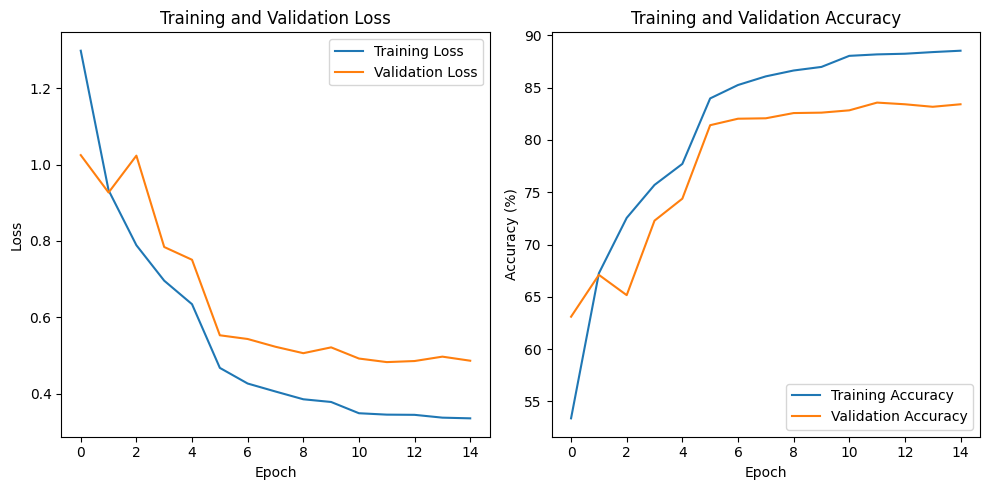

In [22]:
train_and_validate(model, train_loader, valid_loader, test_loader, num_epochs=15, early_stopping_threshold=10, device='cuda:0' ,  save_filename = 'fifth_layer_no_freeze.pth' )

# Fifth Layer CSI - train

100%|██████████| 36/36 [00:00<00:00, 266.13it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 3/3 [00:00<00:00, 2990.24it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 3/3 [00:00<00:00, 3038.62it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 3/3 [00:00<00:00, 2883.34it/s]

Data has been normalized



Calculating CSI: 100%|██████████| 3/3 [00:00<00:00, 3349.19it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 3/3 [00:00<00:00, 2981.03it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 3/3 [00:00<00:00, 2563.23it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 3/3 [00:00<00:00, 3767.34it/s]


[('layer1', 0.4033333361148834), ('layer2', 0.5102222561836243), ('layer3', 0.5915555357933044), ('layer4', 0.6646666526794434), ('layer5', 0.742222249507904), ('fc1', 0.8619999885559082), ('fc2', 0.8297777771949768)]


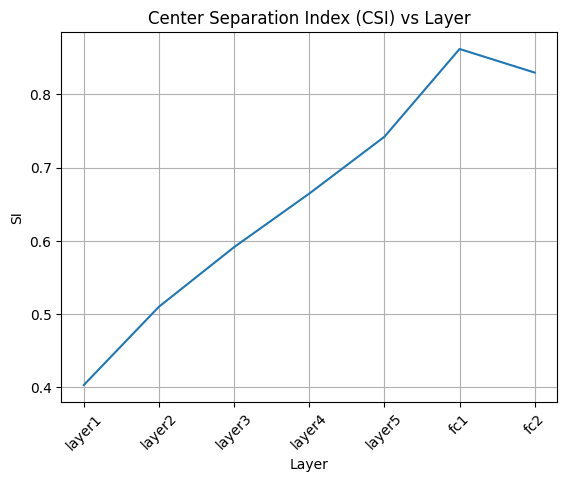

In [26]:
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
model = VGG11_fifth_layer().to(device)
model.load_state_dict(torch.load('fifth_layer_no_freeze.pth'))
model.to('cuda:1' if torch.cuda.is_available() else 'cpu')
model.eval()

# Prepare storage for outputs and labels
features_per_layer = {}
labels_list = []

# Define layers to exclude
exclude_layers = {'' }

# Function to attach hooks
def get_layer_outputs(layer_name):
    def hook(module, input, output):
        features_per_layer[layer_name].append(output.detach())
    return hook

# Attach hooks to each layer except the excluded ones
for name, layer in model.named_children():
    if name not in exclude_layers:
        features_per_layer[name] = []
        layer.register_forward_hook(get_layer_outputs(name))

# Pass data through the model and collect layer outputs
with torch.no_grad():
    for inputs, targets in tqdm(train_loader_SI): 
        inputs = inputs.to('cuda:1' if torch.cuda.is_available() else 'cpu')

        # Trigger the hooks and collect layer outputs
        model(inputs)
        labels_list.append(targets.cpu())

        # Clear CUDA cache after processing each batch
        if torch.cuda.is_available():
            torch.cuda.empty_cache()

# Post-process the data: Flatten and concatenate
for layer_name, layer_features in features_per_layer.items():
    if layer_features:  # Check if layer_features is not empty
        try:
            features_per_layer[layer_name] = torch.cat([f.view(f.size(0), -1) for f in layer_features])
        except RuntimeError as e:
            print(f"Error in concatenating features of layer {layer_name}")
            for f in layer_features:
                print(f.shape)
            raise e
# Concatenate the labels
labels = torch.cat(labels_list)

csi_layer_train = []

# Iterate through each layer's features in the dictionary
for layer_name, features in features_per_layer.items():
    instance_disturbance = ARH_SeparationIndex(features, labels, normalize=True)
    csi = instance_disturbance.center_si_batch(batch_size=2000)
    csi_layer_train.append((layer_name, csi))

print(csi_layer_train)


# Plotting SI versus layer using a line plot
plt.plot([layer for layer, _ in csi_layer_train], [si for _, si in csi_layer_train])
plt.xlabel('Layer')
plt.ylabel('SI')
plt.title('Center Separation Index (CSI) vs Layer')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()    

[('layer1', 0.4033333361148834), ('layer2', 0.5102222561836243), ('layer3', 0.5915555357933044), ('layer4', 0.6646666526794434), ('layer5', 0.742222249507904), ('fc1', 0.8619999885559082), ('fc2', 0.8297777771949768)]


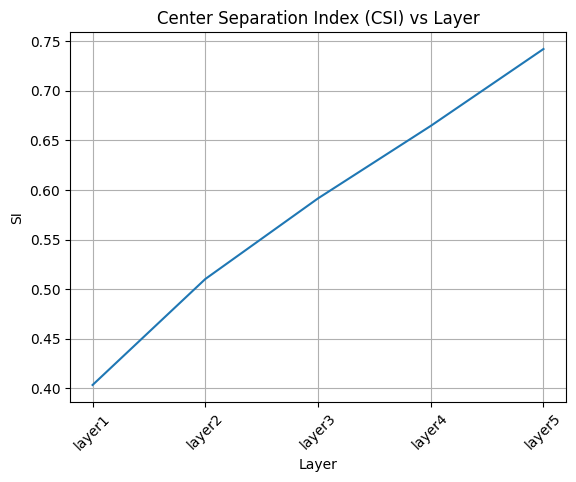

In [27]:
print(csi_layer_train)

# Plotting SI versus layer using a line plot
plt.plot([layer for layer, _ in csi_layer_train[0:-2]], [si for _, si in csi_layer_train[0:-2]])
plt.xlabel('Layer')
plt.ylabel('SI')
plt.title('Center Separation Index (CSI) vs Layer')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

# Fifth Layer CSI - test

100%|██████████| 79/79 [00:01<00:00, 62.30it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 5/5 [00:00<00:00, 3201.27it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 5/5 [00:00<00:00, 4227.28it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 5/5 [00:00<00:00, 3016.18it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 5/5 [00:00<00:00, 4176.76it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 5/5 [00:00<00:00, 4297.44it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 5/5 [00:00<00:00, 3815.08it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 5/5 [00:00<00:00, 4206.08it/s]

[('layer1', 0.4132999777793884), ('layer2', 0.513700008392334), ('layer3', 0.5888999700546265), ('layer4', 0.6640999913215637), ('layer5', 0.7351999878883362), ('fc1', 0.8314999938011169), ('fc2', 0.8069999814033508)]


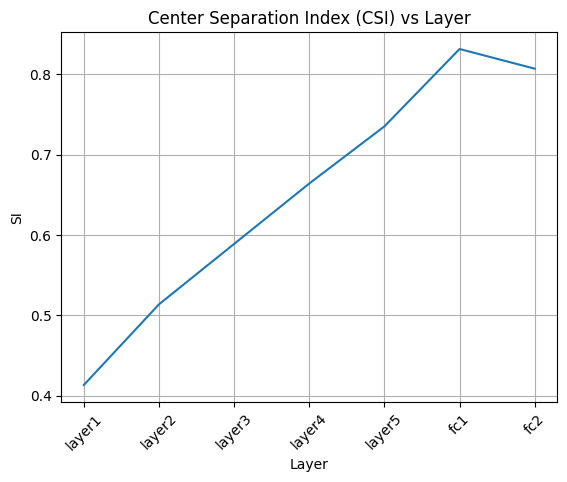

[('layer1', 0.4132999777793884), ('layer2', 0.513700008392334), ('layer3', 0.5888999700546265), ('layer4', 0.6640999913215637), ('layer5', 0.7351999878883362), ('fc1', 0.8314999938011169), ('fc2', 0.8069999814033508)]


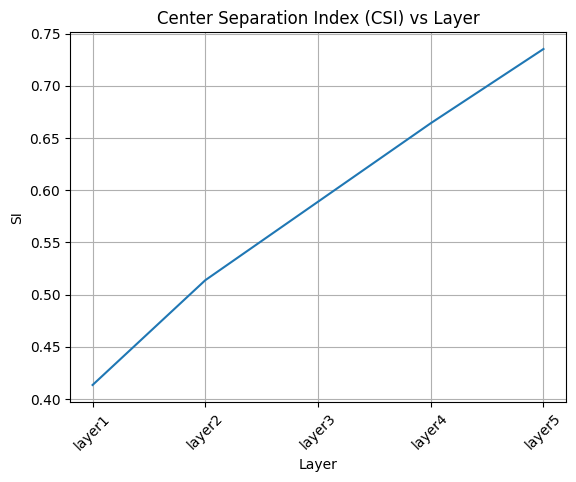

In [19]:
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
model = VGG11_fifth_layer().to(device)
model.load_state_dict(torch.load('fifth_layer_no_freeze.pth'))
model.to('cuda:1' if torch.cuda.is_available() else 'cpu')
model.eval()

# Prepare storage for outputs and labels
features_per_layer = {}
labels_list = []

# Define layers to exclude
exclude_layers = {'' }

# Function to attach hooks
def get_layer_outputs(layer_name):
    def hook(module, input, output):
        features_per_layer[layer_name].append(output.detach())
    return hook

# Attach hooks to each layer except the excluded ones
for name, layer in model.named_children():
    if name not in exclude_layers:
        features_per_layer[name] = []
        layer.register_forward_hook(get_layer_outputs(name))

# Pass data through the model and collect layer outputs
with torch.no_grad():
    for inputs, targets in tqdm(test_loader): 
        inputs = inputs.to('cuda:1' if torch.cuda.is_available() else 'cpu')

        # Trigger the hooks and collect layer outputs
        model(inputs)
        labels_list.append(targets.cpu())

        # Clear CUDA cache after processing each batch
        if torch.cuda.is_available():
            torch.cuda.empty_cache()

# Post-process the data: Flatten and concatenate
for layer_name, layer_features in features_per_layer.items():
    if layer_features:  # Check if layer_features is not empty
        try:
            features_per_layer[layer_name] = torch.cat([f.view(f.size(0), -1) for f in layer_features])
        except RuntimeError as e:
            print(f"Error in concatenating features of layer {layer_name}")
            for f in layer_features:
                print(f.shape)
            raise e
# Concatenate the labels
labels = torch.cat(labels_list)

csi_layer_train = []

# Iterate through each layer's features in the dictionary
for layer_name, features in features_per_layer.items():
    instance_disturbance = ARH_SeparationIndex(features, labels, normalize=True)
    csi = instance_disturbance.center_si_batch(batch_size=2000)
    csi_layer_train.append((layer_name, csi))

print(csi_layer_train)


# Plotting SI versus layer using a line plot
plt.plot([layer for layer, _ in csi_layer_train], [si for _, si in csi_layer_train])
plt.xlabel('Layer')
plt.ylabel('SI')
plt.title('Center Separation Index (CSI) vs Layer')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

print(csi_layer_train)

# Plotting SI versus layer using a line plot
plt.plot([layer for layer, _ in csi_layer_train[0:-2]], [si for _, si in csi_layer_train[0:-2]])
plt.xlabel('Layer')
plt.ylabel('SI')
plt.title('Center Separation Index (CSI) vs Layer')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

# Sixth Layer

In [20]:
import torch.nn as nn

class VGG11_sixth_layer(nn.Module):
    def __init__(self, num_classes=10):
        super(VGG11_sixth_layer, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.layer2 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.layer3 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU()
        )
        self.layer4 = nn.Sequential(
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.layer5 = nn.Sequential(
            nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU()
        )
        self.layer6 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.fc1 = nn.Sequential(
            nn.Linear(512 * 2* 2, 512)
        )
        self.fc2 = nn.Sequential(
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.layer5(out)
        out = self.layer6(out)
        out = out.view(out.size(0), -1)
        out = self.fc1(out)
        out = self.fc2(out)
        return out

In [21]:
import torch
import torch.nn as nn

model = VGG11_sixth_layer().to(device)
model

VGG11_sixth_layer(
  (layer1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (layer4): Sequential(
    (0): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=

  7%|▋         | 1/15 [00:43<10:14, 43.92s/it]

Epoch [1/15], Step [352/352], Training Loss: 1.3231, Training Accuracy: 52.33%, Validation Accuracy: 62.68%, Validation Loss: 1.0746


 13%|█▎        | 2/15 [01:28<09:37, 44.45s/it]

Epoch [2/15], Step [352/352], Training Loss: 0.9238, Training Accuracy: 67.32%, Validation Accuracy: 67.02%, Validation Loss: 0.9564


 20%|██        | 3/15 [02:12<08:51, 44.25s/it]

Epoch [3/15], Step [352/352], Training Loss: 0.7803, Training Accuracy: 72.56%, Validation Accuracy: 73.48%, Validation Loss: 0.7544


 27%|██▋       | 4/15 [02:57<08:07, 44.27s/it]

Epoch [4/15], Step [352/352], Training Loss: 0.6840, Training Accuracy: 75.98%, Validation Accuracy: 71.26%, Validation Loss: 0.8538


 33%|███▎      | 5/15 [03:41<07:22, 44.26s/it]

Epoch [5/15], Step [352/352], Training Loss: 0.6212, Training Accuracy: 78.18%, Validation Accuracy: 74.64%, Validation Loss: 0.7250


 40%|████      | 6/15 [04:25<06:36, 44.10s/it]

Epoch [6/15], Step [352/352], Training Loss: 0.4405, Training Accuracy: 84.79%, Validation Accuracy: 82.28%, Validation Loss: 0.5106


 47%|████▋     | 7/15 [05:10<05:55, 44.46s/it]

Epoch [7/15], Step [352/352], Training Loss: 0.3933, Training Accuracy: 86.30%, Validation Accuracy: 83.22%, Validation Loss: 0.4794


 53%|█████▎    | 8/15 [05:54<05:11, 44.43s/it]

Epoch [8/15], Step [352/352], Training Loss: 0.3728, Training Accuracy: 87.08%, Validation Accuracy: 82.36%, Validation Loss: 0.5009


 60%|██████    | 9/15 [06:39<04:26, 44.50s/it]

Epoch [9/15], Step [352/352], Training Loss: 0.3544, Training Accuracy: 87.80%, Validation Accuracy: 83.02%, Validation Loss: 0.4803


 67%|██████▋   | 10/15 [07:24<03:43, 44.66s/it]

Epoch [10/15], Step [352/352], Training Loss: 0.3377, Training Accuracy: 88.29%, Validation Accuracy: 82.94%, Validation Loss: 0.4939


 73%|███████▎  | 11/15 [08:08<02:58, 44.61s/it]

Epoch [11/15], Step [352/352], Training Loss: 0.3073, Training Accuracy: 89.52%, Validation Accuracy: 83.72%, Validation Loss: 0.4723


 80%|████████  | 12/15 [08:53<02:14, 44.72s/it]

Epoch [12/15], Step [352/352], Training Loss: 0.3033, Training Accuracy: 89.79%, Validation Accuracy: 83.98%, Validation Loss: 0.4602


 87%|████████▋ | 13/15 [09:38<01:29, 44.69s/it]

Epoch [13/15], Step [352/352], Training Loss: 0.2986, Training Accuracy: 89.75%, Validation Accuracy: 83.66%, Validation Loss: 0.4616


 93%|█████████▎| 14/15 [10:22<00:44, 44.55s/it]

Epoch [14/15], Step [352/352], Training Loss: 0.2989, Training Accuracy: 89.96%, Validation Accuracy: 84.08%, Validation Loss: 0.4618


100%|██████████| 15/15 [11:08<00:00, 44.60s/it]

Epoch [15/15], Step [352/352], Training Loss: 0.2965, Training Accuracy: 89.89%, Validation Accuracy: 83.66%, Validation Loss: 0.4615


Test Set Accuracy on Best Weights: 85.20%


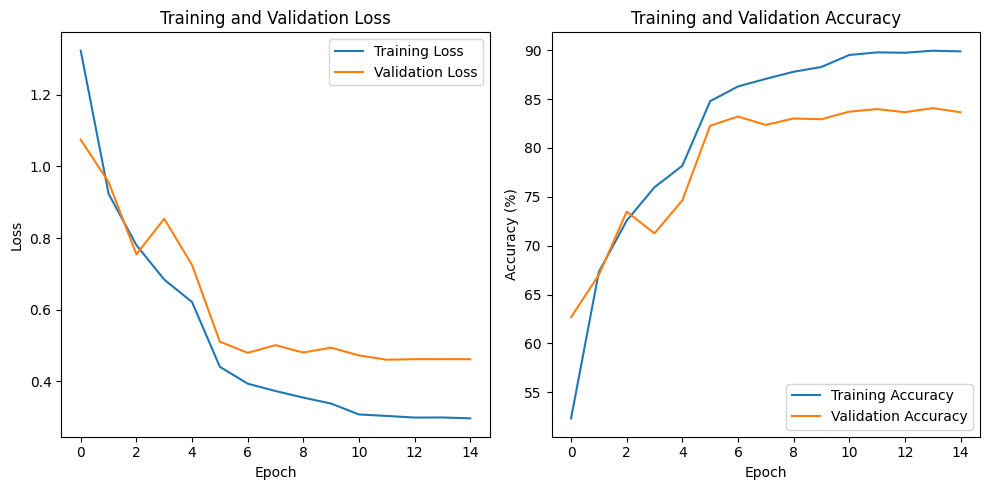

In [25]:
train_and_validate(model, train_loader, valid_loader, test_loader, num_epochs=15, early_stopping_threshold=10, device='cuda:0' ,  save_filename = 'sixth_layer_no_freeze.pth' )

# Sixth Layer CSI - train

100%|██████████| 36/36 [00:00<00:00, 250.22it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 3/3 [00:00<00:00, 2239.35it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 3/3 [00:00<00:00, 3200.13it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 3/3 [00:00<00:00, 1962.09it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 3/3 [00:00<00:00, 2943.37it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 3/3 [00:00<00:00, 3099.24it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 3/3 [00:00<00:00, 2769.13it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 3/3 [00:00<00:00, 1978.76it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 3/3 [00:00<00:00, 3158.36it/s]


[('layer1', 0.4153333306312561), ('layer2', 0.508222222328186), ('layer3', 0.5833333134651184), ('layer4', 0.6531111001968384), ('layer5', 0.737333357334137), ('layer6', 0.8117777705192566), ('fc1', 0.8768888711929321), ('fc2', 0.8451111316680908)]


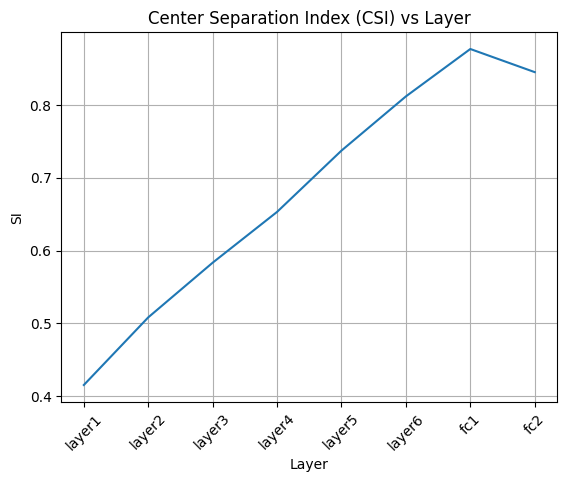

In [30]:
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
model = VGG11_sixth_layer().to(device)
model.load_state_dict(torch.load('sixth_layer_no_freeze.pth'))
model.to('cuda:1' if torch.cuda.is_available() else 'cpu')
model.eval()

# Prepare storage for outputs and labels
features_per_layer = {}
labels_list = []

# Define layers to exclude
exclude_layers = {'' }

# Function to attach hooks
def get_layer_outputs(layer_name):
    def hook(module, input, output):
        features_per_layer[layer_name].append(output.detach())
    return hook

# Attach hooks to each layer except the excluded ones
for name, layer in model.named_children():
    if name not in exclude_layers:
        features_per_layer[name] = []
        layer.register_forward_hook(get_layer_outputs(name))

# Pass data through the model and collect layer outputs
with torch.no_grad():
    for inputs, targets in tqdm(train_loader_SI): 
        inputs = inputs.to('cuda:1' if torch.cuda.is_available() else 'cpu')

        # Trigger the hooks and collect layer outputs
        model(inputs)
        labels_list.append(targets.cpu())

        # Clear CUDA cache after processing each batch
        if torch.cuda.is_available():
            torch.cuda.empty_cache()

# Post-process the data: Flatten and concatenate
for layer_name, layer_features in features_per_layer.items():
    if layer_features:  # Check if layer_features is not empty
        try:
            features_per_layer[layer_name] = torch.cat([f.view(f.size(0), -1) for f in layer_features])
        except RuntimeError as e:
            print(f"Error in concatenating features of layer {layer_name}")
            for f in layer_features:
                print(f.shape)
            raise e
# Concatenate the labels
labels = torch.cat(labels_list)

csi_layer_train = []

# Iterate through each layer's features in the dictionary
for layer_name, features in features_per_layer.items():
    instance_disturbance = ARH_SeparationIndex(features, labels, normalize=True)
    csi = instance_disturbance.center_si_batch(batch_size=2000)
    csi_layer_train.append((layer_name, csi))

print(csi_layer_train)


# Plotting SI versus layer using a line plot
plt.plot([layer for layer, _ in csi_layer_train], [si for _, si in csi_layer_train])
plt.xlabel('Layer')
plt.ylabel('SI')
plt.title('Center Separation Index (CSI) vs Layer')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()    

[('layer1', 0.4153333306312561), ('layer2', 0.508222222328186), ('layer3', 0.5833333134651184), ('layer4', 0.6531111001968384), ('layer5', 0.737333357334137), ('layer6', 0.8117777705192566), ('fc1', 0.8768888711929321), ('fc2', 0.8451111316680908)]


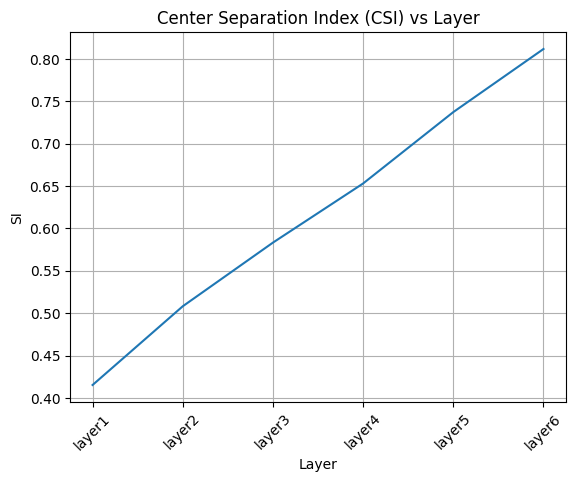

In [31]:
print(csi_layer_train)


# Plotting SI versus layer using a line plot
plt.plot([layer for layer, _ in csi_layer_train[0:-2]], [si for _, si in csi_layer_train[0:-2]])
plt.xlabel('Layer')
plt.ylabel('SI')
plt.title('Center Separation Index (CSI) vs Layer')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

# Sixth Layer CSI - test

100%|██████████| 79/79 [00:01<00:00, 60.42it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 5/5 [00:00<00:00, 3071.40it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 5/5 [00:00<00:00, 4052.47it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 5/5 [00:00<00:00, 2925.31it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 5/5 [00:00<00:00, 4334.75it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 5/5 [00:00<00:00, 4292.17it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 5/5 [00:00<00:00, 3980.17it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 5/5 [00:00<00:00, 4415.06it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 5/5 [00:00<00:00, 4191.79it/s]


[('layer1', 0.4227999746799469), ('layer2', 0.5055999755859375), ('layer3', 0.5824999809265137), ('layer4', 0.6547999978065491), ('layer5', 0.7217999696731567), ('layer6', 0.7895999550819397), ('fc1', 0.8392999768257141), ('fc2', 0.8123999834060669)]


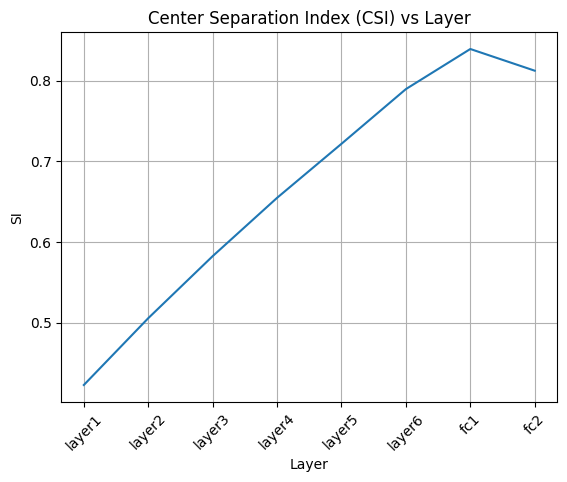

[('layer1', 0.4227999746799469), ('layer2', 0.5055999755859375), ('layer3', 0.5824999809265137), ('layer4', 0.6547999978065491), ('layer5', 0.7217999696731567), ('layer6', 0.7895999550819397), ('fc1', 0.8392999768257141), ('fc2', 0.8123999834060669)]


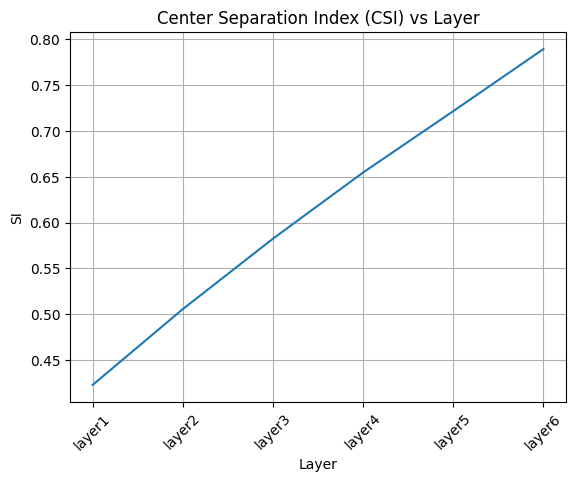

In [22]:
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
model = VGG11_sixth_layer().to(device)
model.load_state_dict(torch.load('sixth_layer_no_freeze.pth'))
model.to('cuda:1' if torch.cuda.is_available() else 'cpu')
model.eval()

# Prepare storage for outputs and labels
features_per_layer = {}
labels_list = []

# Define layers to exclude
exclude_layers = {'' }

# Function to attach hooks
def get_layer_outputs(layer_name):
    def hook(module, input, output):
        features_per_layer[layer_name].append(output.detach())
    return hook

# Attach hooks to each layer except the excluded ones
for name, layer in model.named_children():
    if name not in exclude_layers:
        features_per_layer[name] = []
        layer.register_forward_hook(get_layer_outputs(name))

# Pass data through the model and collect layer outputs
with torch.no_grad():
    for inputs, targets in tqdm(test_loader): 
        inputs = inputs.to('cuda:1' if torch.cuda.is_available() else 'cpu')

        # Trigger the hooks and collect layer outputs
        model(inputs)
        labels_list.append(targets.cpu())

        # Clear CUDA cache after processing each batch
        if torch.cuda.is_available():
            torch.cuda.empty_cache()

# Post-process the data: Flatten and concatenate
for layer_name, layer_features in features_per_layer.items():
    if layer_features:  # Check if layer_features is not empty
        try:
            features_per_layer[layer_name] = torch.cat([f.view(f.size(0), -1) for f in layer_features])
        except RuntimeError as e:
            print(f"Error in concatenating features of layer {layer_name}")
            for f in layer_features:
                print(f.shape)
            raise e
# Concatenate the labels
labels = torch.cat(labels_list)

csi_layer_train = []

# Iterate through each layer's features in the dictionary
for layer_name, features in features_per_layer.items():
    instance_disturbance = ARH_SeparationIndex(features, labels, normalize=True)
    csi = instance_disturbance.center_si_batch(batch_size=2000)
    csi_layer_train.append((layer_name, csi))

print(csi_layer_train)


# Plotting SI versus layer using a line plot
plt.plot([layer for layer, _ in csi_layer_train], [si for _, si in csi_layer_train])
plt.xlabel('Layer')
plt.ylabel('SI')
plt.title('Center Separation Index (CSI) vs Layer')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()   

print(csi_layer_train)


# Plotting SI versus layer using a line plot
plt.plot([layer for layer, _ in csi_layer_train[0:-2]], [si for _, si in csi_layer_train[0:-2]])
plt.xlabel('Layer')
plt.ylabel('SI')
plt.title('Center Separation Index (CSI) vs Layer')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

# seventh Layer

In [23]:
import torch.nn as nn

class VGG11_seven_layer(nn.Module):
    def __init__(self, num_classes=10):
        super(VGG11_seven_layer, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.layer2 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.layer3 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU()
        )
        self.layer4 = nn.Sequential(
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.layer5 = nn.Sequential(
            nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU()
        )
        self.layer6 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.layer7 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU()
        )
        self.fc1 = nn.Sequential(
            nn.Linear(512 * 2 * 2, 512)
        )
        self.fc2 = nn.Sequential(
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.layer5(out)
        out = self.layer6(out)
        out = self.layer7(out)
        out = out.view(out.size(0), -1)
        out = self.fc1(out)
        out = self.fc2(out)
        return out

In [24]:
import torch
import torch.nn as nn

model = VGG11_seven_layer().to(device)

model

VGG11_seven_layer(
  (layer1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (layer4): Sequential(
    (0): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=

  7%|▋         | 1/15 [00:44<10:27, 44.80s/it]

Epoch [1/15], Step [352/352], Training Loss: 1.3005, Training Accuracy: 53.06%, Validation Accuracy: 59.14%, Validation Loss: 1.1970


 13%|█▎        | 2/15 [01:30<09:50, 45.44s/it]

Epoch [2/15], Step [352/352], Training Loss: 0.9094, Training Accuracy: 67.88%, Validation Accuracy: 69.68%, Validation Loss: 0.8878


 20%|██        | 3/15 [02:15<09:04, 45.34s/it]

Epoch [3/15], Step [352/352], Training Loss: 0.7627, Training Accuracy: 73.34%, Validation Accuracy: 70.82%, Validation Loss: 0.8280


 27%|██▋       | 4/15 [03:00<08:17, 45.22s/it]

Epoch [4/15], Step [352/352], Training Loss: 0.6619, Training Accuracy: 76.80%, Validation Accuracy: 75.02%, Validation Loss: 0.7220


 33%|███▎      | 5/15 [03:46<07:32, 45.29s/it]

Epoch [5/15], Step [352/352], Training Loss: 0.6046, Training Accuracy: 79.06%, Validation Accuracy: 74.84%, Validation Loss: 0.7439


 40%|████      | 6/15 [04:31<06:46, 45.18s/it]

Epoch [6/15], Step [352/352], Training Loss: 0.4365, Training Accuracy: 84.92%, Validation Accuracy: 82.40%, Validation Loss: 0.5148


 47%|████▋     | 7/15 [05:16<06:02, 45.33s/it]

Epoch [7/15], Step [352/352], Training Loss: 0.3848, Training Accuracy: 86.69%, Validation Accuracy: 82.68%, Validation Loss: 0.5471


 53%|█████▎    | 8/15 [06:01<05:15, 45.11s/it]

Epoch [8/15], Step [352/352], Training Loss: 0.3651, Training Accuracy: 87.33%, Validation Accuracy: 82.70%, Validation Loss: 0.4928


 60%|██████    | 9/15 [06:46<04:30, 45.16s/it]

Epoch [9/15], Step [352/352], Training Loss: 0.3427, Training Accuracy: 88.21%, Validation Accuracy: 82.96%, Validation Loss: 0.5152


 67%|██████▋   | 10/15 [07:31<03:45, 45.10s/it]

Epoch [10/15], Step [352/352], Training Loss: 0.3279, Training Accuracy: 88.64%, Validation Accuracy: 83.58%, Validation Loss: 0.4809


 73%|███████▎  | 11/15 [08:16<02:59, 44.92s/it]

Epoch [11/15], Step [352/352], Training Loss: 0.2958, Training Accuracy: 89.73%, Validation Accuracy: 83.80%, Validation Loss: 0.4728


 80%|████████  | 12/15 [09:01<02:15, 45.14s/it]

Epoch [12/15], Step [352/352], Training Loss: 0.2886, Training Accuracy: 90.16%, Validation Accuracy: 83.32%, Validation Loss: 0.4688


 87%|████████▋ | 13/15 [09:46<01:29, 44.88s/it]

Epoch [13/15], Step [352/352], Training Loss: 0.2855, Training Accuracy: 90.19%, Validation Accuracy: 83.26%, Validation Loss: 0.4693


 93%|█████████▎| 14/15 [10:31<00:45, 45.11s/it]

Epoch [14/15], Step [352/352], Training Loss: 0.2819, Training Accuracy: 90.43%, Validation Accuracy: 83.86%, Validation Loss: 0.4746


100%|██████████| 15/15 [11:16<00:00, 45.10s/it]

Epoch [15/15], Step [352/352], Training Loss: 0.2805, Training Accuracy: 90.48%, Validation Accuracy: 83.70%, Validation Loss: 0.4696


Test Set Accuracy on Best Weights: 85.37%


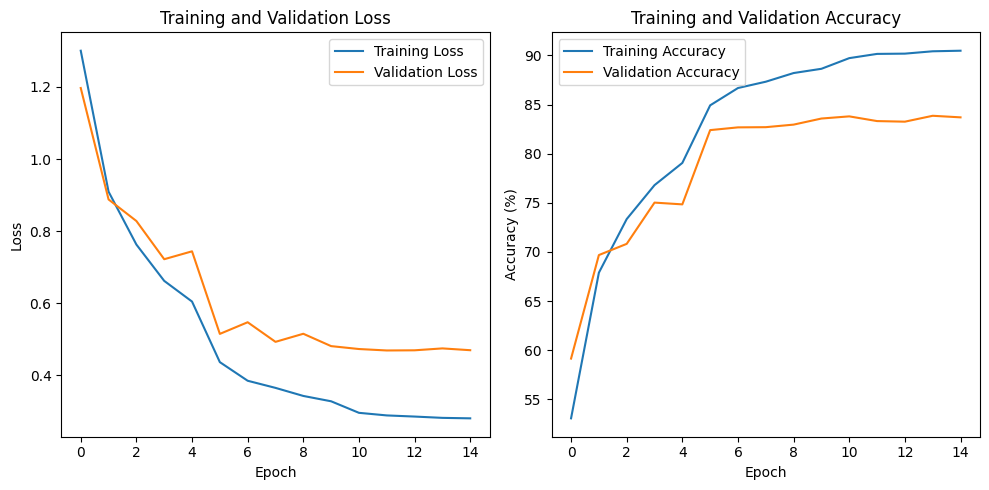

In [28]:
train_and_validate(model, train_loader, valid_loader, test_loader, num_epochs=15, early_stopping_threshold=10, device='cuda:0' ,  save_filename = 'seventh_layer_no_freeze.pth' )

# Seventh Layer CSI - train

100%|██████████| 36/36 [00:00<00:00, 222.54it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 3/3 [00:00<00:00, 2038.38it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 3/3 [00:00<00:00, 3079.52it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 3/3 [00:00<00:00, 2173.59it/s]

Data has been normalized



Calculating CSI: 100%|██████████| 3/3 [00:00<00:00, 3047.45it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 3/3 [00:00<00:00, 2804.30it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 3/3 [00:00<00:00, 3010.99it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 3/3 [00:00<00:00, 2935.82it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 3/3 [00:00<00:00, 1542.02it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 3/3 [00:00<00:00, 2547.15it/s]


[('layer1', 0.4122222363948822), ('layer2', 0.5117777585983276), ('layer3', 0.5873333215713501), ('layer4', 0.6575555801391602), ('layer5', 0.730222225189209), ('layer6', 0.8155555725097656), ('layer7', 0.8684444427490234), ('fc1', 0.8835555911064148), ('fc2', 0.8680000305175781)]


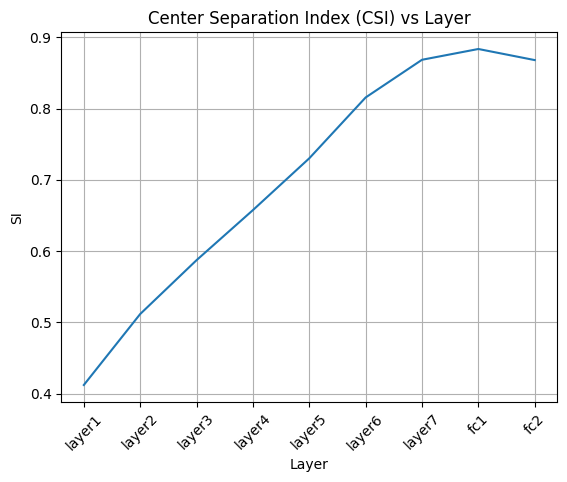

In [34]:
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
model = VGG11_seven_layer().to(device)
model.load_state_dict(torch.load('seventh_layer_no_freeze.pth'))
model.to('cuda:1' if torch.cuda.is_available() else 'cpu')
model.eval()

# Prepare storage for outputs and labels
features_per_layer = {}
labels_list = []

# Define layers to exclude
exclude_layers = {'' }

# Function to attach hooks
def get_layer_outputs(layer_name):
    def hook(module, input, output):
        features_per_layer[layer_name].append(output.detach())
    return hook

# Attach hooks to each layer except the excluded ones
for name, layer in model.named_children():
    if name not in exclude_layers:
        features_per_layer[name] = []
        layer.register_forward_hook(get_layer_outputs(name))

# Pass data through the model and collect layer outputs
with torch.no_grad():
    for inputs, targets in tqdm(train_loader_SI): 
        inputs = inputs.to('cuda:1' if torch.cuda.is_available() else 'cpu')

        # Trigger the hooks and collect layer outputs
        model(inputs)
        labels_list.append(targets.cpu())

        # Clear CUDA cache after processing each batch
        if torch.cuda.is_available():
            torch.cuda.empty_cache()

# Post-process the data: Flatten and concatenate
for layer_name, layer_features in features_per_layer.items():
    if layer_features:  # Check if layer_features is not empty
        try:
            features_per_layer[layer_name] = torch.cat([f.view(f.size(0), -1) for f in layer_features])
        except RuntimeError as e:
            print(f"Error in concatenating features of layer {layer_name}")
            for f in layer_features:
                print(f.shape)
            raise e
# Concatenate the labels
labels = torch.cat(labels_list)

csi_layer_train = []

# Iterate through each layer's features in the dictionary
for layer_name, features in features_per_layer.items():
    instance_disturbance = ARH_SeparationIndex(features, labels, normalize=True)
    csi = instance_disturbance.center_si_batch(batch_size=2000)
    csi_layer_train.append((layer_name, csi))

print(csi_layer_train)


# Plotting SI versus layer using a line plot
plt.plot([layer for layer, _ in csi_layer_train], [si for _, si in csi_layer_train])
plt.xlabel('Layer')
plt.ylabel('SI')
plt.title('Center Separation Index (CSI) vs Layer')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()    

[('layer1', 0.4122222363948822), ('layer2', 0.5117777585983276), ('layer3', 0.5873333215713501), ('layer4', 0.6575555801391602), ('layer5', 0.730222225189209), ('layer6', 0.8155555725097656), ('layer7', 0.8684444427490234), ('fc1', 0.8835555911064148), ('fc2', 0.8680000305175781)]


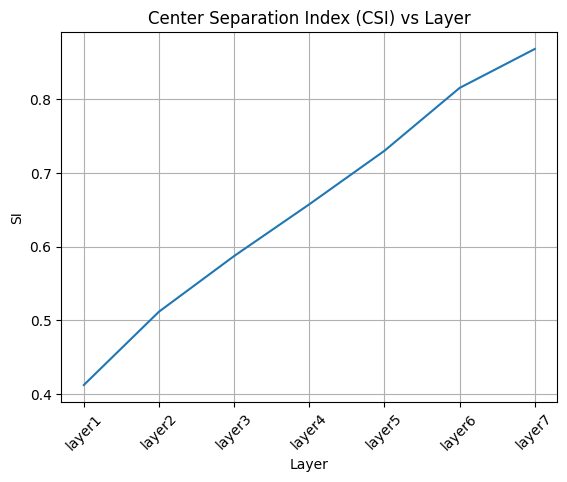

In [35]:
print(csi_layer_train)


# Plotting SI versus layer using a line plot
plt.plot([layer for layer, _ in csi_layer_train[0:-2]], [si for _, si in csi_layer_train[0:-2]])
plt.xlabel('Layer')
plt.ylabel('SI')
plt.title('Center Separation Index (CSI) vs Layer')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

# Seventh Layer CSI - test

100%|██████████| 79/79 [00:01<00:00, 58.94it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 5/5 [00:00<00:00, 2863.40it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 5/5 [00:00<00:00, 4316.90it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 5/5 [00:00<00:00, 3057.52it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 5/5 [00:00<00:00, 4286.02it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 5/5 [00:00<00:00, 4317.79it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 5/5 [00:00<00:00, 4502.26it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 5/5 [00:00<00:00, 4227.28it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 5/5 [00:00<00:00, 4094.40it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 5/5 [00:00<00:00, 4053.25it/s]


[('layer1', 0.4235000014305115), ('layer2', 0.515500009059906), ('layer3', 0.5845000147819519), ('layer4', 0.6561999917030334), ('layer5', 0.7202000021934509), ('layer6', 0.793999969959259), ('layer7', 0.8341999650001526), ('fc1', 0.8447999954223633), ('fc2', 0.8326999545097351)]


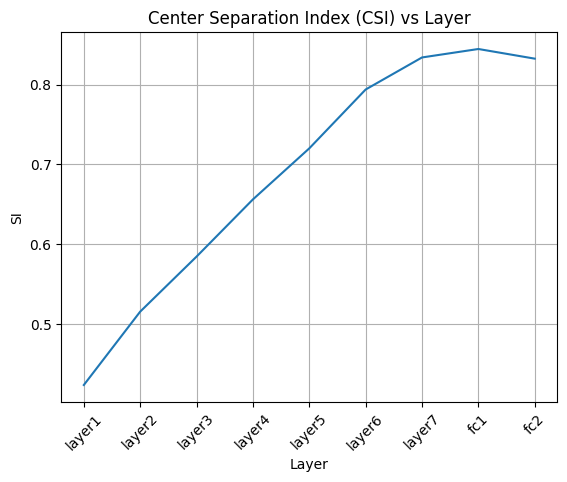

[('layer1', 0.4235000014305115), ('layer2', 0.515500009059906), ('layer3', 0.5845000147819519), ('layer4', 0.6561999917030334), ('layer5', 0.7202000021934509), ('layer6', 0.793999969959259), ('layer7', 0.8341999650001526), ('fc1', 0.8447999954223633), ('fc2', 0.8326999545097351)]


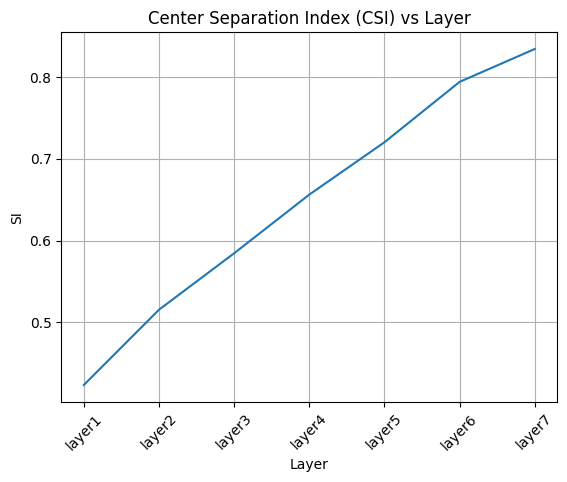

In [25]:
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
model = VGG11_seven_layer().to(device)
model.load_state_dict(torch.load('seventh_layer_no_freeze.pth'))
model.to('cuda:1' if torch.cuda.is_available() else 'cpu')
model.eval()

# Prepare storage for outputs and labels
features_per_layer = {}
labels_list = []

# Define layers to exclude
exclude_layers = {'' }

# Function to attach hooks
def get_layer_outputs(layer_name):
    def hook(module, input, output):
        features_per_layer[layer_name].append(output.detach())
    return hook

# Attach hooks to each layer except the excluded ones
for name, layer in model.named_children():
    if name not in exclude_layers:
        features_per_layer[name] = []
        layer.register_forward_hook(get_layer_outputs(name))

# Pass data through the model and collect layer outputs
with torch.no_grad():
    for inputs, targets in tqdm(test_loader): 
        inputs = inputs.to('cuda:1' if torch.cuda.is_available() else 'cpu')

        # Trigger the hooks and collect layer outputs
        model(inputs)
        labels_list.append(targets.cpu())

        # Clear CUDA cache after processing each batch
        if torch.cuda.is_available():
            torch.cuda.empty_cache()

# Post-process the data: Flatten and concatenate
for layer_name, layer_features in features_per_layer.items():
    if layer_features:  # Check if layer_features is not empty
        try:
            features_per_layer[layer_name] = torch.cat([f.view(f.size(0), -1) for f in layer_features])
        except RuntimeError as e:
            print(f"Error in concatenating features of layer {layer_name}")
            for f in layer_features:
                print(f.shape)
            raise e
# Concatenate the labels
labels = torch.cat(labels_list)

csi_layer_train = []

# Iterate through each layer's features in the dictionary
for layer_name, features in features_per_layer.items():
    instance_disturbance = ARH_SeparationIndex(features, labels, normalize=True)
    csi = instance_disturbance.center_si_batch(batch_size=2000)
    csi_layer_train.append((layer_name, csi))

print(csi_layer_train)


# Plotting SI versus layer using a line plot
plt.plot([layer for layer, _ in csi_layer_train], [si for _, si in csi_layer_train])
plt.xlabel('Layer')
plt.ylabel('SI')
plt.title('Center Separation Index (CSI) vs Layer')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()    

print(csi_layer_train)


# Plotting SI versus layer using a line plot
plt.plot([layer for layer, _ in csi_layer_train[0:-2]], [si for _, si in csi_layer_train[0:-2]])
plt.xlabel('Layer')
plt.ylabel('SI')
plt.title('Center Separation Index (CSI) vs Layer')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

# Eighth Layer

In [26]:
import torch.nn as nn

class VGG11_eighth_layer(nn.Module):
    def __init__(self, num_classes=10):
        super(VGG11_eighth_layer, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.layer2 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.layer3 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU()
        )
        self.layer4 = nn.Sequential(
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.layer5 = nn.Sequential(
            nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU()
        )
        self.layer6 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.layer7 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU()
        )
        self.layer8 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.fc1 = nn.Sequential(
            nn.Linear(512, 512)
        )
        self.fc2 = nn.Sequential(
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.layer5(out)
        out = self.layer6(out)
        out = self.layer7(out)
        out = self.layer8(out)
        out = out.view(out.size(0), -1)
        out = self.fc1(out)
        out = self.fc2(out)
        return out

In [27]:
import torch
import torch.nn as nn


model = VGG11_eighth_layer().to(device)

model

VGG11_eighth_layer(
  (layer1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (layer4): Sequential(
    (0): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats

  7%|▋         | 1/15 [00:45<10:42, 45.92s/it]

Epoch [1/15], Step [352/352], Training Loss: 1.3234, Training Accuracy: 51.96%, Validation Accuracy: 59.72%, Validation Loss: 1.1650


 13%|█▎        | 2/15 [01:30<09:47, 45.17s/it]

Epoch [2/15], Step [352/352], Training Loss: 0.9334, Training Accuracy: 66.93%, Validation Accuracy: 68.04%, Validation Loss: 0.9557


 20%|██        | 3/15 [02:16<09:05, 45.47s/it]

Epoch [3/15], Step [352/352], Training Loss: 0.7813, Training Accuracy: 72.58%, Validation Accuracy: 72.78%, Validation Loss: 0.7819


 27%|██▋       | 4/15 [03:01<08:18, 45.29s/it]

Epoch [4/15], Step [352/352], Training Loss: 0.6941, Training Accuracy: 75.81%, Validation Accuracy: 71.86%, Validation Loss: 0.8589


 33%|███▎      | 5/15 [03:48<07:38, 45.86s/it]

Epoch [5/15], Step [352/352], Training Loss: 0.6164, Training Accuracy: 78.43%, Validation Accuracy: 75.82%, Validation Loss: 0.6984


 40%|████      | 6/15 [04:34<06:52, 45.82s/it]

Epoch [6/15], Step [352/352], Training Loss: 0.4428, Training Accuracy: 84.61%, Validation Accuracy: 81.94%, Validation Loss: 0.5145


 47%|████▋     | 7/15 [05:19<06:04, 45.57s/it]

Epoch [7/15], Step [352/352], Training Loss: 0.3948, Training Accuracy: 86.32%, Validation Accuracy: 82.40%, Validation Loss: 0.5021


 53%|█████▎    | 8/15 [06:05<05:19, 45.71s/it]

Epoch [8/15], Step [352/352], Training Loss: 0.3721, Training Accuracy: 86.92%, Validation Accuracy: 82.42%, Validation Loss: 0.5141


 60%|██████    | 9/15 [06:50<04:32, 45.47s/it]

Epoch [9/15], Step [352/352], Training Loss: 0.3502, Training Accuracy: 87.80%, Validation Accuracy: 82.86%, Validation Loss: 0.5199


 67%|██████▋   | 10/15 [07:35<03:47, 45.46s/it]

Epoch [10/15], Step [352/352], Training Loss: 0.3288, Training Accuracy: 88.62%, Validation Accuracy: 83.30%, Validation Loss: 0.4926


 73%|███████▎  | 11/15 [08:21<03:02, 45.53s/it]

Epoch [11/15], Step [352/352], Training Loss: 0.3002, Training Accuracy: 89.76%, Validation Accuracy: 84.02%, Validation Loss: 0.4796


 80%|████████  | 12/15 [09:06<02:16, 45.37s/it]

Epoch [12/15], Step [352/352], Training Loss: 0.2900, Training Accuracy: 89.99%, Validation Accuracy: 83.92%, Validation Loss: 0.4720


 87%|████████▋ | 13/15 [09:51<01:30, 45.48s/it]

Epoch [13/15], Step [352/352], Training Loss: 0.2876, Training Accuracy: 90.11%, Validation Accuracy: 84.44%, Validation Loss: 0.4751


 93%|█████████▎| 14/15 [10:36<00:45, 45.28s/it]

Epoch [14/15], Step [352/352], Training Loss: 0.2841, Training Accuracy: 90.17%, Validation Accuracy: 83.72%, Validation Loss: 0.4750


100%|██████████| 15/15 [11:23<00:00, 45.55s/it]

Epoch [15/15], Step [352/352], Training Loss: 0.2778, Training Accuracy: 90.50%, Validation Accuracy: 83.78%, Validation Loss: 0.4969


Test Set Accuracy on Best Weights: 84.88%


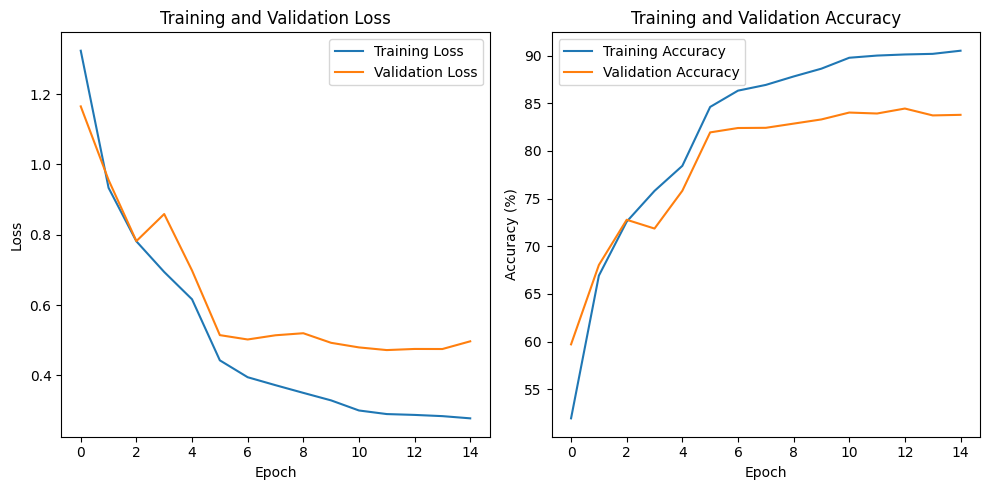

In [31]:
train_and_validate(model, train_loader, valid_loader, test_loader, num_epochs=15, early_stopping_threshold=10, device='cuda:0' ,  save_filename = 'eighth_layer_no_freeze.pth' )

# Eighth Layer CSI - train

100%|██████████| 36/36 [00:00<00:00, 200.76it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 3/3 [00:00<00:00, 3134.76it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 3/3 [00:00<00:00, 3109.96it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 3/3 [00:00<00:00, 3045.24it/s]

Data has been normalized



Calculating CSI: 100%|██████████| 3/3 [00:00<00:00, 3028.38it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 3/3 [00:00<00:00, 3100.00it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 3/3 [00:00<00:00, 2948.89it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 3/3 [00:00<00:00, 3145.73it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 3/3 [00:00<00:00, 2170.96it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 3/3 [00:00<00:00, 1927.53it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 3/3 [00:00<00:00, 3274.24it/s]

[('layer1', 0.4131111204624176), ('layer2', 0.5088889002799988), ('layer3', 0.59333336353302), ('layer4', 0.6448888778686523), ('layer5', 0.7211111187934875), ('layer6', 0.8124444484710693), ('layer7', 0.8753333687782288), ('layer8', 0.8893333673477173), ('fc1', 0.8957777619361877), ('fc2', 0.8884444832801819)]


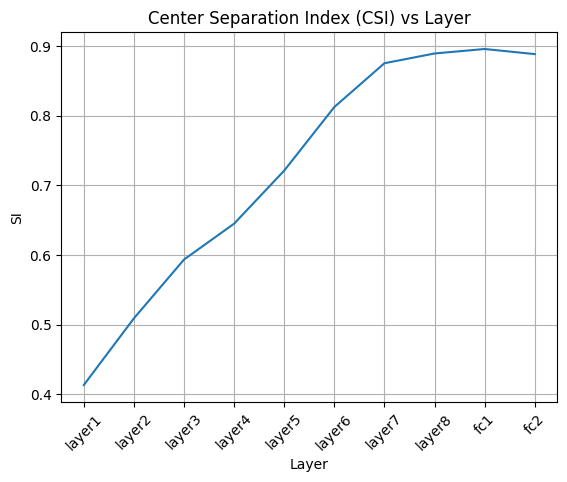

In [38]:
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
model = VGG11_eighth_layer().to(device)
model.load_state_dict(torch.load('eighth_layer_no_freeze.pth'))
model.to('cuda:1' if torch.cuda.is_available() else 'cpu')
model.eval()

# Prepare storage for outputs and labels
features_per_layer = {}
labels_list = []

# Define layers to exclude
exclude_layers = {'' }

# Function to attach hooks
def get_layer_outputs(layer_name):
    def hook(module, input, output):
        features_per_layer[layer_name].append(output.detach())
    return hook

# Attach hooks to each layer except the excluded ones
for name, layer in model.named_children():
    if name not in exclude_layers:
        features_per_layer[name] = []
        layer.register_forward_hook(get_layer_outputs(name))

# Pass data through the model and collect layer outputs
with torch.no_grad():
    for inputs, targets in tqdm(train_loader_SI): 
        inputs = inputs.to('cuda:1' if torch.cuda.is_available() else 'cpu')

        # Trigger the hooks and collect layer outputs
        model(inputs)
        labels_list.append(targets.cpu())

        # Clear CUDA cache after processing each batch
        if torch.cuda.is_available():
            torch.cuda.empty_cache()

# Post-process the data: Flatten and concatenate
for layer_name, layer_features in features_per_layer.items():
    if layer_features:  # Check if layer_features is not empty
        try:
            features_per_layer[layer_name] = torch.cat([f.view(f.size(0), -1) for f in layer_features])
        except RuntimeError as e:
            print(f"Error in concatenating features of layer {layer_name}")
            for f in layer_features:
                print(f.shape)
            raise e
# Concatenate the labels
labels = torch.cat(labels_list)

csi_layer_train = []

# Iterate through each layer's features in the dictionary
for layer_name, features in features_per_layer.items():
    instance_disturbance = ARH_SeparationIndex(features, labels, normalize=True)
    csi = instance_disturbance.center_si_batch(batch_size=2000)
    csi_layer_train.append((layer_name, csi))

print(csi_layer_train)


# Plotting SI versus layer using a line plot
plt.plot([layer for layer, _ in csi_layer_train], [si for _, si in csi_layer_train])
plt.xlabel('Layer')
plt.ylabel('SI')
plt.title('Center Separation Index (CSI) vs Layer')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()    

[('layer1', 0.4131111204624176), ('layer2', 0.5088889002799988), ('layer3', 0.59333336353302), ('layer4', 0.6448888778686523), ('layer5', 0.7211111187934875), ('layer6', 0.8124444484710693), ('layer7', 0.8753333687782288), ('layer8', 0.8893333673477173), ('fc1', 0.8957777619361877), ('fc2', 0.8884444832801819)]


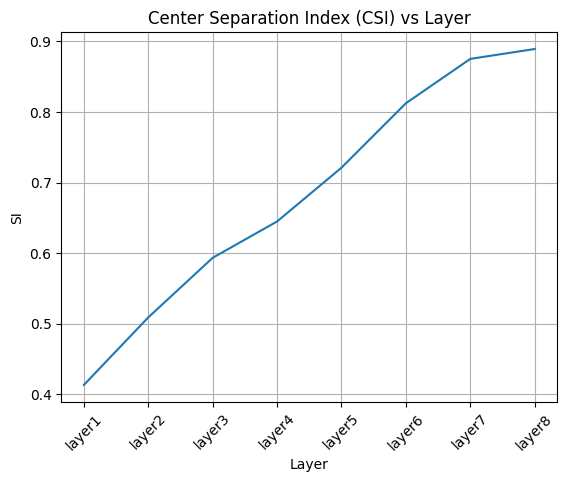

In [39]:
print(csi_layer_train)

# Plotting SI versus layer using a line plot
plt.plot([layer for layer, _ in csi_layer_train[0:-2]], [si for _, si in csi_layer_train[0:-2]])
plt.xlabel('Layer')
plt.ylabel('SI')
plt.title('Center Separation Index (CSI) vs Layer')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

# Eighth Layer CSI - test

100%|██████████| 79/79 [00:01<00:00, 58.12it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 5/5 [00:00<00:00, 2901.83it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 5/5 [00:00<00:00, 4034.54it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 5/5 [00:00<00:00, 3224.40it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 5/5 [00:00<00:00, 4516.80it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 5/5 [00:00<00:00, 4215.38it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 5/5 [00:00<00:00, 4359.98it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 5/5 [00:00<00:00, 4256.45it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 5/5 [00:00<00:00, 4258.18it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 5/5 [00:00<00:00, 4286.90it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 5/5 [00:00<00:00, 4514.86it/s]

[('layer1', 0.4244999885559082), ('layer2', 0.5141000151634216), ('layer3', 0.5898999571800232), ('layer4', 0.6566999554634094), ('layer5', 0.715499997138977), ('layer6', 0.7849999666213989), ('layer7', 0.8328999876976013), ('layer8', 0.8361999988555908), ('fc1', 0.8434999585151672), ('fc2', 0.8335999846458435)]


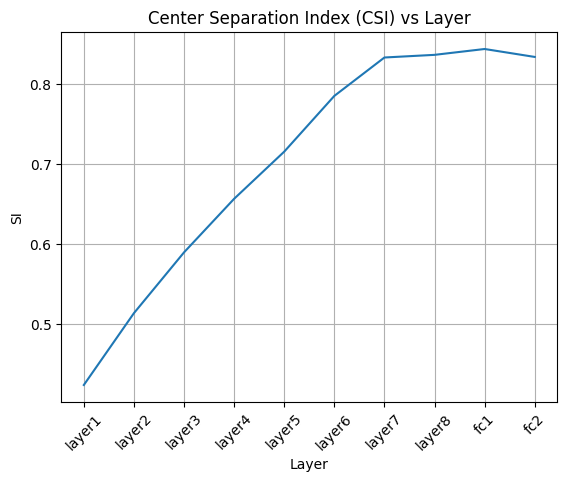

[('layer1', 0.4244999885559082), ('layer2', 0.5141000151634216), ('layer3', 0.5898999571800232), ('layer4', 0.6566999554634094), ('layer5', 0.715499997138977), ('layer6', 0.7849999666213989), ('layer7', 0.8328999876976013), ('layer8', 0.8361999988555908), ('fc1', 0.8434999585151672), ('fc2', 0.8335999846458435)]


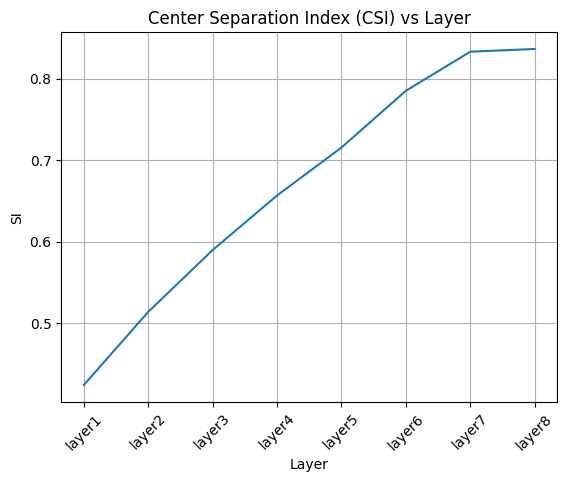

In [28]:
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
model = VGG11_eighth_layer().to(device)
model.load_state_dict(torch.load('eighth_layer_no_freeze.pth'))
model.to('cuda:1' if torch.cuda.is_available() else 'cpu')
model.eval()

# Prepare storage for outputs and labels
features_per_layer = {}
labels_list = []

# Define layers to exclude
exclude_layers = {'' }

# Function to attach hooks
def get_layer_outputs(layer_name):
    def hook(module, input, output):
        features_per_layer[layer_name].append(output.detach())
    return hook

# Attach hooks to each layer except the excluded ones
for name, layer in model.named_children():
    if name not in exclude_layers:
        features_per_layer[name] = []
        layer.register_forward_hook(get_layer_outputs(name))

# Pass data through the model and collect layer outputs
with torch.no_grad():
    for inputs, targets in tqdm(test_loader): 
        inputs = inputs.to('cuda:1' if torch.cuda.is_available() else 'cpu')

        # Trigger the hooks and collect layer outputs
        model(inputs)
        labels_list.append(targets.cpu())

        # Clear CUDA cache after processing each batch
        if torch.cuda.is_available():
            torch.cuda.empty_cache()

# Post-process the data: Flatten and concatenate
for layer_name, layer_features in features_per_layer.items():
    if layer_features:  # Check if layer_features is not empty
        try:
            features_per_layer[layer_name] = torch.cat([f.view(f.size(0), -1) for f in layer_features])
        except RuntimeError as e:
            print(f"Error in concatenating features of layer {layer_name}")
            for f in layer_features:
                print(f.shape)
            raise e
# Concatenate the labels
labels = torch.cat(labels_list)

csi_layer_train = []

# Iterate through each layer's features in the dictionary
for layer_name, features in features_per_layer.items():
    instance_disturbance = ARH_SeparationIndex(features, labels, normalize=True)
    csi = instance_disturbance.center_si_batch(batch_size=2000)
    csi_layer_train.append((layer_name, csi))

print(csi_layer_train)


# Plotting SI versus layer using a line plot
plt.plot([layer for layer, _ in csi_layer_train], [si for _, si in csi_layer_train])
plt.xlabel('Layer')
plt.ylabel('SI')
plt.title('Center Separation Index (CSI) vs Layer')
plt.xticks(rotation=45)
plt.grid(True)
plt.show() 


print(csi_layer_train)

# Plotting SI versus layer using a line plot
plt.plot([layer for layer, _ in csi_layer_train[0:-2]], [si for _, si in csi_layer_train[0:-2]])
plt.xlabel('Layer')
plt.ylabel('SI')
plt.title('Center Separation Index (CSI) vs Layer')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()